In [ ]:
# STEP 0: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 1: Import libraries
import pandas as pd
import os

In [ ]:
# STEP 2: Define input & output paths
input_file = "/content/drive/MyDrive/credit_project/application_train.csv"
output_dir = "/content/drive/MyDrive/credit_project/app_train_parts"

# Make sure output dir exists
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# STEP 3: Check if file exists
if not os.path.exists(input_file):
    raise FileNotFoundError(f"❌ File not found: {input_file}. Please check the filename in your Drive.")

In [ ]:
# STEP 4: Process file in chunks
chunksize = 100_000  # adjust if needed

reader = pd.read_csv(input_file, chunksize=chunksize)

for i, chunk in enumerate(reader):
    print(f"✅ Processing chunk {i} with shape {chunk.shape}...")

    # Example cleaning (light, safe for now)
    chunk = chunk.drop_duplicates()

    # Save each batch as parquet
    output_path = os.path.join(output_dir, f"app_train_part{i}.parquet")
    chunk.to_parquet(output_path, index=False)

print("🎉 Done splitting application_train into smaller parquet files.")


✅ Processing chunk 0 with shape (100000, 122)...
✅ Processing chunk 1 with shape (100000, 122)...
✅ Processing chunk 2 with shape (100000, 122)...
✅ Processing chunk 3 with shape (7511, 122)...
🎉 Done splitting application_train into smaller parquet files.


Step 2: Safe recombination.
We’ll recombine all parquet parts on demand, but still in a batchwise way so RAM doesn’t explode.

In [ ]:
# STEP 0: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 1: Import libraries
import pandas as pd
import os

# STEP 2: Define input & output paths
input_file = "/content/drive/MyDrive/credit_project/application_train.csv"
output_dir = "/content/drive/MyDrive/credit_project/app_train_parts"
os.makedirs(output_dir, exist_ok=True)

# STEP 3: Check if input file exists
if not os.path.exists(input_file):
    raise FileNotFoundError(f"❌ File not found: {input_file}. Please check the filename in your Drive.")

# STEP 4: Checkpointed processing (split CSV into parquet parts)
existing_parts = [f for f in os.listdir(output_dir) if f.endswith(".parquet")]

if len(existing_parts) > 0:
    print(f"⚡ Found {len(existing_parts)} existing parquet parts in '{output_dir}'. Skipping CSV reprocessing.")
else:
    print("⏳ No parquet parts found. Processing CSV in chunks...")
    chunksize = 100_000  # adjust if needed
    reader = pd.read_csv(input_file, chunksize=chunksize)

    for i, chunk in enumerate(reader):
        print(f"✅ Processing chunk {i} with shape {chunk.shape}...")
        chunk = chunk.drop_duplicates()  # Light cleaning
        output_path = os.path.join(output_dir, f"app_train_part{i}.parquet")
        chunk.to_parquet(output_path, index=False)

    print("🎉 Done splitting application_train into smaller parquet files.")

# STEP 5: Safe batch loader
def load_application_train_in_batches(parts_dir, batch_size=2):
    """
    Loads parquet parts in smaller batches to avoid RAM crashes.
    Example: batch_size=2 loads 2 parts at a time.
    """
    files = sorted([f for f in os.listdir(parts_dir) if f.endswith(".parquet")])
    files = [os.path.join(parts_dir, f) for f in files]

    print(f"Found {len(files)} parquet parts.")

    for i in range(0, len(files), batch_size):
        batch_files = files[i:i+batch_size]
        dfs = [pd.read_parquet(f) for f in batch_files]
        batch_df = pd.concat(dfs, ignore_index=True)
        print(f"🔹 Loaded batch {i//batch_size} with shape {batch_df.shape}")
        yield batch_df

# Example usage (safe iteration)
for batch in load_application_train_in_batches(output_dir, batch_size=2):
    print(batch.head(2))
    break  # remove break to process all batches


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚡ Found 4 existing parquet parts in '/content/drive/MyDrive/credit_project/app_train_parts'. Skipping CSV reprocessing.
Found 4 parquet parts.
🔹 Loaded batch 0 with shape (200000, 122)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   

  AMT

In [ ]:
# Step 2: Batchwise Loading of bureau.csv with checkpoints
import pandas as pd
import os

# Input & output paths
bureau_file = "/content/drive/MyDrive/credit_project/bureau.csv"
bureau_output_dir = "/content/drive/MyDrive/credit_project/bureau_parts"
os.makedirs(bureau_output_dir, exist_ok=True)

# Define chunk size
chunksize = 100_000

# --- Checkpoint logic ---
existing_parts = [f for f in os.listdir(bureau_output_dir) if f.endswith(".parquet")]

if len(existing_parts) > 0:
    print(f"⚡ Found {len(existing_parts)} existing parquet parts in '{bureau_output_dir}'. Skipping CSV reprocessing.")
else:
    # Process CSV into parquet chunks only if not already done
    if not os.path.exists(bureau_file):
        raise FileNotFoundError(f"❌ Error: The file '{bureau_file}' was not found. Check path.")

    print("⏳ No parquet parts found. Processing bureau.csv in chunks...")
    reader = pd.read_csv(bureau_file, chunksize=chunksize)

    for i, chunk in enumerate(reader):
        print(f"✅ Processing bureau chunk {i} with shape {chunk.shape}...")
        chunk = chunk.drop_duplicates()  # optional cleaning
        output_path = os.path.join(bureau_output_dir, f"bureau_part{i}.parquet")
        chunk.to_parquet(output_path, index=False)

    print("🎉 Done splitting bureau.csv into smaller parquet files.")


⚡ Found 18 existing parquet parts in '/content/drive/MyDrive/credit_project/bureau_parts'. Skipping CSV reprocessing.


In [ ]:
# Step 3: Batchwise Loading of bureau_balance.csv with checkpoints
import pandas as pd
import os

# Input & output paths
bureau_balance_file = "/content/drive/MyDrive/credit_project/bureau_balance.csv"
bureau_balance_output_dir = "/content/drive/MyDrive/credit_project/bureau_balance_parts"
os.makedirs(bureau_balance_output_dir, exist_ok=True)

# Define chunk size
chunksize = 100_000

# --- Checkpoint logic ---
existing_parts = [f for f in os.listdir(bureau_balance_output_dir) if f.endswith(".parquet")]

if len(existing_parts) > 0:
    print(f"⚡ Found {len(existing_parts)} existing parquet parts in '{bureau_balance_output_dir}'. Skipping CSV reprocessing.")
else:
    # Process CSV into parquet chunks only if not already done
    if not os.path.exists(bureau_balance_file):
        raise FileNotFoundError(f"❌ Error: The file '{bureau_balance_file}' was not found. Check path.")

    print("⏳ No parquet parts found. Processing bureau_balance.csv in chunks...")
    reader = pd.read_csv(bureau_balance_file, chunksize=chunksize)

    for i, chunk in enumerate(reader):
        print(f"✅ Processing bureau_balance chunk {i} with shape {chunk.shape}...")
        chunk = chunk.drop_duplicates()  # optional cleaning
        output_path = os.path.join(bureau_balance_output_dir, f"bureau_balance_part{i}.parquet")
        chunk.to_parquet(output_path, index=False)

    print("🎉 Done splitting bureau_balance.csv into smaller parquet files.")


⚡ Found 273 existing parquet parts in '/content/drive/MyDrive/credit_project/bureau_balance_parts'. Skipping CSV reprocessing.


In [ ]:
# Step 4: Batchwise Loading of previous_application.csv with checkpoints
import pandas as pd
import os

# Input & output paths
previous_app_file = "/content/drive/MyDrive/credit_project/previous_application.csv"
previous_app_output_dir = "/content/drive/MyDrive/credit_project/previous_app_parts"
os.makedirs(previous_app_output_dir, exist_ok=True)

# Define chunk size
chunksize = 100_000

# --- Checkpoint logic ---
existing_parts = [f for f in os.listdir(previous_app_output_dir) if f.endswith(".parquet")]

if len(existing_parts) > 0:
    print(f"⚡ Found {len(existing_parts)} existing parquet parts in '{previous_app_output_dir}'. Skipping CSV reprocessing.")
else:
    # Process CSV into parquet chunks only if not already done
    if not os.path.exists(previous_app_file):
        raise FileNotFoundError(f"❌ Error: The file '{previous_app_file}' was not found. Check path.")

    print("⏳ No parquet parts found. Processing previous_application.csv in chunks...")
    reader = pd.read_csv(previous_app_file, chunksize=chunksize)

    for i, chunk in enumerate(reader):
        print(f"✅ Processing previous_application chunk {i} with shape {chunk.shape}...")
        chunk = chunk.drop_duplicates()  # optional cleaning
        output_path = os.path.join(previous_app_output_dir, f"previous_app_part{i}.parquet")
        chunk.to_parquet(output_path, index=False)

    print("🎉 Done splitting previous_application.csv into smaller parquet files.")


⚡ Found 17 existing parquet parts in '/content/drive/MyDrive/credit_project/previous_app_parts'. Skipping CSV reprocessing.


In [ ]:
# Step 5: Batchwise Loading of POS_CASH_balance.csv with checkpoints
import pandas as pd
import os

# Input & output paths
pos_cash_file = "/content/drive/MyDrive/credit_project/POS_CASH_balance.csv"
pos_cash_output_dir = "/content/drive/MyDrive/credit_project/pos_cash_parts"
os.makedirs(pos_cash_output_dir, exist_ok=True)

# Define chunk size
chunksize = 100_000

# --- Checkpoint logic ---
existing_parts = [f for f in os.listdir(pos_cash_output_dir) if f.endswith(".parquet")]

if len(existing_parts) > 0:
    print(f"⚡ Found {len(existing_parts)} existing parquet parts in '{pos_cash_output_dir}'. Skipping CSV reprocessing.")
else:
    # Process CSV into parquet chunks only if not already done
    if not os.path.exists(pos_cash_file):
        raise FileNotFoundError(f"❌ Error: The file '{pos_cash_file}' was not found. Check path.")

    print("⏳ No parquet parts found. Processing POS_CASH_balance.csv in chunks...")
    reader = pd.read_csv(pos_cash_file, chunksize=chunksize)

    for i, chunk in enumerate(reader):
        print(f"✅ Processing POS_CASH_balance chunk {i} with shape {chunk.shape}...")
        chunk = chunk.drop_duplicates()  # optional cleaning
        output_path = os.path.join(pos_cash_output_dir, f"pos_cash_part{i}.parquet")
        chunk.to_parquet(output_path, index=False)

    print("🎉 Done splitting POS_CASH_balance.csv into smaller parquet files.")


⚡ Found 101 existing parquet parts in '/content/drive/MyDrive/credit_project/pos_cash_parts'. Skipping CSV reprocessing.


In [ ]:
# Step 6: Batchwise Loading of installments_payments.csv with checkpoints
import pandas as pd
import os

# Input & output paths
installments_file = "/content/drive/MyDrive/credit_project/installments_payments.csv"
installments_output_dir = "/content/drive/MyDrive/credit_project/installments_parts"
os.makedirs(installments_output_dir, exist_ok=True)

# Define chunk size
chunksize = 100_000

# --- Checkpoint logic ---
existing_parts = [f for f in os.listdir(installments_output_dir) if f.endswith(".parquet")]

if len(existing_parts) > 0:
    print(f"⚡ Found {len(existing_parts)} existing parquet parts in '{installments_output_dir}'. Skipping CSV reprocessing.")
else:
    # Process CSV into parquet chunks only if not already done
    if not os.path.exists(installments_file):
        raise FileNotFoundError(f"❌ Error: The file '{installments_file}' was not found. Check path.")

    print("⏳ No parquet parts found. Processing installments_payments.csv in chunks...")
    reader = pd.read_csv(installments_file, chunksize=chunksize)

    for i, chunk in enumerate(reader):
        print(f"✅ Processing installments_payments chunk {i} with shape {chunk.shape}...")
        chunk = chunk.drop_duplicates()  # optional cleaning
        output_path = os.path.join(installments_output_dir, f"installments_part{i}.parquet")
        chunk.to_parquet(output_path, index=False)

    print("🎉 Done splitting installments_payments.csv into smaller parquet files.")


⚡ Found 137 existing parquet parts in '/content/drive/MyDrive/credit_project/installments_parts'. Skipping CSV reprocessing.


In [ ]:
# Step 7: Batchwise Loading of credit_card_balance.csv with checkpoints
import pandas as pd
import os

# Input & output paths
credit_file = "/content/drive/MyDrive/credit_project/credit_card_balance.csv"
credit_output_dir = "/content/drive/MyDrive/credit_project/credit_parts"
os.makedirs(credit_output_dir, exist_ok=True)

# Define chunk size
chunksize = 100_000

# --- Checkpoint logic ---
existing_parts = [f for f in os.listdir(credit_output_dir) if f.endswith(".parquet")]

if len(existing_parts) > 0:
    print(f"⚡ Found {len(existing_parts)} existing parquet parts in '{credit_output_dir}'. Skipping CSV reprocessing.")
else:
    # Process CSV into parquet chunks only if not already done
    if not os.path.exists(credit_file):
        raise FileNotFoundError(f"❌ Error: The file '{credit_file}' was not found. Check path.")

    print("⏳ No parquet parts found. Processing credit_card_balance.csv in chunks...")
    reader = pd.read_csv(credit_file, chunksize=chunksize)

    for i, chunk in enumerate(reader):
        print(f"✅ Processing credit_card_balance chunk {i} with shape {chunk.shape}...")
        chunk = chunk.drop_duplicates()  # optional cleaning
        output_path = os.path.join(credit_output_dir, f"credit_part{i}.parquet")
        chunk.to_parquet(output_path, index=False)

    print("🎉 Done splitting credit_card_balance.csv into smaller parquet files.")


⚡ Found 39 existing parquet parts in '/content/drive/MyDrive/credit_project/credit_parts'. Skipping CSV reprocessing.


In [ ]:
# Step 8: Clean application_train parts (checkpoint-friendly)

import pandas as pd
import os

# Input and output directories
input_dir = "/content/drive/MyDrive/credit_project/app_train_parts"
output_dir = "/content/drive/MyDrive/credit_project/app_train_clean_parts"
os.makedirs(output_dir, exist_ok=True)

# List all split parquet files
files = sorted([f for f in os.listdir(input_dir) if f.endswith(".parquet")])

# Track already processed files
existing_clean = set(os.listdir(output_dir))

for i, file in enumerate(files):
    output_name = f"app_train_clean_part{i}.parquet"
    output_path = os.path.join(output_dir, output_name)

    # Skip if already processed
    if output_name in existing_clean:
        print(f"⏩ Skipping {file} (already cleaned)")
        continue

    print(f"Processing {file} ...")
    part_path = os.path.join(input_dir, file)
    df = pd.read_parquet(part_path)

    # --- Basic Cleaning ---
    # Drop duplicate rows within this part
    df = df.drop_duplicates()

    # Handle NaNs: fill with median for numeric, mode for categorical
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        else:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Save cleaned part
    df.to_parquet(output_path, index=False)
    print(f"✅ Saved cleaned part {i} with shape {df.shape}")

print("🎉 Step 8 Completed: All application_train parts cleaned and saved (checkpointed).")


⏩ Skipping app_train_part0.parquet (already cleaned)
⏩ Skipping app_train_part1.parquet (already cleaned)
⏩ Skipping app_train_part2.parquet (already cleaned)
⏩ Skipping app_train_part3.parquet (already cleaned)
🎉 Step 8 Completed: All application_train parts cleaned and saved (checkpointed).


In [ ]:
# Step 9: Clean bureau parts (checkpoint-friendly)

import pandas as pd
import os

# Input and output directories
input_dir = "/content/drive/MyDrive/credit_project/bureau_parts"
output_dir = "/content/drive/MyDrive/credit_project/bureau_clean_parts"
os.makedirs(output_dir, exist_ok=True)

# List all split parquet files
files = sorted([f for f in os.listdir(input_dir) if f.endswith(".parquet")])

# Track already processed files
existing_clean = set(os.listdir(output_dir))

for i, file in enumerate(files):
    output_name = f"bureau_clean_part{i}.parquet"
    output_path = os.path.join(output_dir, output_name)

    # Skip if already processed
    if output_name in existing_clean:
        print(f"⏩ Skipping {file} (already cleaned)")
        continue

    print(f"Processing {file} ...")
    part_path = os.path.join(input_dir, file)
    df = pd.read_parquet(part_path)

    # --- Basic Cleaning ---
    # Drop duplicate rows
    df = df.drop_duplicates()

    # Handle NaNs: fill with median for numeric, mode for categorical
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        else:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Save cleaned part
    df.to_parquet(output_path, index=False)
    print(f"✅ Saved cleaned bureau part {i} with shape {df.shape}")

print("🎉 Step 9 Completed: All bureau parts cleaned and saved (checkpointed).")


⏩ Skipping bureau_part0.parquet (already cleaned)
⏩ Skipping bureau_part1.parquet (already cleaned)
⏩ Skipping bureau_part10.parquet (already cleaned)
⏩ Skipping bureau_part11.parquet (already cleaned)
⏩ Skipping bureau_part12.parquet (already cleaned)
⏩ Skipping bureau_part13.parquet (already cleaned)
⏩ Skipping bureau_part14.parquet (already cleaned)
⏩ Skipping bureau_part15.parquet (already cleaned)
⏩ Skipping bureau_part16.parquet (already cleaned)
⏩ Skipping bureau_part17.parquet (already cleaned)
⏩ Skipping bureau_part2.parquet (already cleaned)
⏩ Skipping bureau_part3.parquet (already cleaned)
⏩ Skipping bureau_part4.parquet (already cleaned)
⏩ Skipping bureau_part5.parquet (already cleaned)
⏩ Skipping bureau_part6.parquet (already cleaned)
⏩ Skipping bureau_part7.parquet (already cleaned)
⏩ Skipping bureau_part8.parquet (already cleaned)
⏩ Skipping bureau_part9.parquet (already cleaned)
🎉 Step 9 Completed: All bureau parts cleaned and saved (checkpointed).


In [ ]:
# Step 10: Clean bureau_balance parts (checkpoint-friendly)

import pandas as pd
import os

# Input and output directories
input_dir = "/content/drive/MyDrive/credit_project/bureau_balance_parts"
output_dir = "/content/drive/MyDrive/credit_project/bureau_balance_clean_parts"
os.makedirs(output_dir, exist_ok=True)

# List all split parquet files
files = sorted([f for f in os.listdir(input_dir) if f.endswith(".parquet")])

# Track already processed files
existing_clean = set(os.listdir(output_dir))

for i, file in enumerate(files):
    output_name = f"bureau_balance_clean_part{i}.parquet"
    output_path = os.path.join(output_dir, output_name)

    # Skip if already processed
    if output_name in existing_clean:
        print(f"⏩ Skipping {file} (already cleaned)")
        continue

    print(f"Processing {file} ...")
    part_path = os.path.join(input_dir, file)
    df = pd.read_parquet(part_path)

    # --- Basic Cleaning ---
    # Drop duplicate rows
    df = df.drop_duplicates()

    # Handle NaNs: fill with median for numeric, mode for categorical
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        else:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Save cleaned part
    df.to_parquet(output_path, index=False)
    print(f"✅ Saved cleaned bureau_balance part {i} with shape {df.shape}")

print("🎉 Step 10 Completed: All bureau_balance parts cleaned and saved (checkpointed).")


⏩ Skipping bureau_balance_part0.parquet (already cleaned)
⏩ Skipping bureau_balance_part1.parquet (already cleaned)
⏩ Skipping bureau_balance_part10.parquet (already cleaned)
⏩ Skipping bureau_balance_part100.parquet (already cleaned)
⏩ Skipping bureau_balance_part101.parquet (already cleaned)
⏩ Skipping bureau_balance_part102.parquet (already cleaned)
⏩ Skipping bureau_balance_part103.parquet (already cleaned)
⏩ Skipping bureau_balance_part104.parquet (already cleaned)
⏩ Skipping bureau_balance_part105.parquet (already cleaned)
⏩ Skipping bureau_balance_part106.parquet (already cleaned)
⏩ Skipping bureau_balance_part107.parquet (already cleaned)
⏩ Skipping bureau_balance_part108.parquet (already cleaned)
⏩ Skipping bureau_balance_part109.parquet (already cleaned)
⏩ Skipping bureau_balance_part11.parquet (already cleaned)
⏩ Skipping bureau_balance_part110.parquet (already cleaned)
⏩ Skipping bureau_balance_part111.parquet (already cleaned)
⏩ Skipping bureau_balance_part112.parquet (alr

In [ ]:
# Step 11: Clean POS_CASH_balance parts (checkpoint-friendly)

import pandas as pd
import os

# Input and output directories
input_dir = "/content/drive/MyDrive/credit_project/pos_cash_parts"
output_dir = "/content/drive/MyDrive/credit_project/POS_CASH_balance_clean_parts"
os.makedirs(output_dir, exist_ok=True)

# List all split parquet files
files = sorted([f for f in os.listdir(input_dir) if f.endswith(".parquet")])

# Track already processed files
existing_clean = set(os.listdir(output_dir))

for i, file in enumerate(files):
    output_name = f"POS_CASH_balance_clean_part{i}.parquet"
    output_path = os.path.join(output_dir, output_name)

    # Skip if already processed
    if output_name in existing_clean:
        print(f"⏩ Skipping {file} (already cleaned)")
        continue

    print(f"Processing {file} ...")
    part_path = os.path.join(input_dir, file)
    df = pd.read_parquet(part_path)

    # --- Basic Cleaning ---
    # Drop duplicate rows
    df = df.drop_duplicates()

    # Handle NaNs: fill with median for numeric, mode for categorical
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        else:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Save cleaned part
    df.to_parquet(output_path, index=False)
    print(f"✅ Saved cleaned POS_CASH_balance part {i} with shape {df.shape}")

print("🎉 Step 11 Completed: All POS_CASH_balance parts cleaned and saved (checkpointed).")


⏩ Skipping pos_cash_part0.parquet (already cleaned)
⏩ Skipping pos_cash_part1.parquet (already cleaned)
⏩ Skipping pos_cash_part10.parquet (already cleaned)
⏩ Skipping pos_cash_part100.parquet (already cleaned)
⏩ Skipping pos_cash_part11.parquet (already cleaned)
⏩ Skipping pos_cash_part12.parquet (already cleaned)
⏩ Skipping pos_cash_part13.parquet (already cleaned)
⏩ Skipping pos_cash_part14.parquet (already cleaned)
⏩ Skipping pos_cash_part15.parquet (already cleaned)
⏩ Skipping pos_cash_part16.parquet (already cleaned)
⏩ Skipping pos_cash_part17.parquet (already cleaned)
⏩ Skipping pos_cash_part18.parquet (already cleaned)
⏩ Skipping pos_cash_part19.parquet (already cleaned)
⏩ Skipping pos_cash_part2.parquet (already cleaned)
⏩ Skipping pos_cash_part20.parquet (already cleaned)
⏩ Skipping pos_cash_part21.parquet (already cleaned)
⏩ Skipping pos_cash_part22.parquet (already cleaned)
⏩ Skipping pos_cash_part23.parquet (already cleaned)
⏩ Skipping pos_cash_part24.parquet (already clea

In [ ]:
# Step 12: Clean credit_card_balance parts (checkpoint-friendly)

import pandas as pd
import os

# Input and output directories
input_dir = "/content/drive/MyDrive/credit_project/credit_parts"
output_dir = "/content/drive/MyDrive/credit_project/credit_card_balance_clean_parts"
os.makedirs(output_dir, exist_ok=True)

# List all split parquet files
files = sorted([f for f in os.listdir(input_dir) if f.endswith(".parquet")])

# Track already processed files
existing_clean = set(os.listdir(output_dir))

for i, file in enumerate(files):
    output_name = f"credit_card_balance_clean_part{i}.parquet"
    output_path = os.path.join(output_dir, output_name)

    # Skip if already processed
    if output_name in existing_clean:
        print(f"⏩ Skipping {file} (already cleaned)")
        continue

    print(f"Processing {file} ...")
    part_path = os.path.join(input_dir, file)
    df = pd.read_parquet(part_path)

    # --- Basic Cleaning ---
    # Drop duplicate rows
    df = df.drop_duplicates()

    # Handle NaNs: fill with median for numeric, mode for categorical
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        else:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Save cleaned part
    df.to_parquet(output_path, index=False)
    print(f"✅ Saved cleaned credit_card_balance part {i} with shape {df.shape}")

print("🎉 Step 12 Completed: All credit_card_balance parts cleaned and saved (checkpointed).")


⏩ Skipping credit_part0.parquet (already cleaned)
⏩ Skipping credit_part1.parquet (already cleaned)
⏩ Skipping credit_part10.parquet (already cleaned)
⏩ Skipping credit_part11.parquet (already cleaned)
⏩ Skipping credit_part12.parquet (already cleaned)
⏩ Skipping credit_part13.parquet (already cleaned)
⏩ Skipping credit_part14.parquet (already cleaned)
⏩ Skipping credit_part15.parquet (already cleaned)
⏩ Skipping credit_part16.parquet (already cleaned)
⏩ Skipping credit_part17.parquet (already cleaned)
⏩ Skipping credit_part18.parquet (already cleaned)
⏩ Skipping credit_part19.parquet (already cleaned)
⏩ Skipping credit_part2.parquet (already cleaned)
⏩ Skipping credit_part20.parquet (already cleaned)
⏩ Skipping credit_part21.parquet (already cleaned)
⏩ Skipping credit_part22.parquet (already cleaned)
⏩ Skipping credit_part23.parquet (already cleaned)
⏩ Skipping credit_part24.parquet (already cleaned)
⏩ Skipping credit_part25.parquet (already cleaned)
⏩ Skipping credit_part26.parquet (

In [ ]:
# Step 13: Clean installments_payments parts (checkpoint-friendly)

import pandas as pd
import os

# Input and output directories
input_dir = "/content/drive/MyDrive/credit_project/installments_parts"
output_dir = "/content/drive/MyDrive/credit_project/installments_payments_clean_parts"
os.makedirs(output_dir, exist_ok=True)

# List all split parquet files
files = sorted([f for f in os.listdir(input_dir) if f.endswith(".parquet")])

# Track already processed files
existing_clean = set(os.listdir(output_dir))

for i, file in enumerate(files):
    output_name = f"installments_payments_clean_part{i}.parquet"
    output_path = os.path.join(output_dir, output_name)

    # Skip if already processed
    if output_name in existing_clean:
        print(f"⏩ Skipping {file} (already cleaned)")
        continue

    print(f"Processing {file} ...")
    part_path = os.path.join(input_dir, file)
    df = pd.read_parquet(part_path)

    # --- Basic Cleaning ---
    # Drop duplicate rows
    df = df.drop_duplicates()

    # Handle NaNs: fill with median for numeric, mode for categorical
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        else:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Save cleaned part
    df.to_parquet(output_path, index=False)
    print(f"✅ Saved cleaned installments_payments part {i} with shape {df.shape}")

print("🎉 Step 13 Completed: All installments_payments parts cleaned and saved (checkpointed).")


⏩ Skipping installments_part0.parquet (already cleaned)
⏩ Skipping installments_part1.parquet (already cleaned)
⏩ Skipping installments_part10.parquet (already cleaned)
⏩ Skipping installments_part100.parquet (already cleaned)
⏩ Skipping installments_part101.parquet (already cleaned)
⏩ Skipping installments_part102.parquet (already cleaned)
⏩ Skipping installments_part103.parquet (already cleaned)
⏩ Skipping installments_part104.parquet (already cleaned)
⏩ Skipping installments_part105.parquet (already cleaned)
⏩ Skipping installments_part106.parquet (already cleaned)
⏩ Skipping installments_part107.parquet (already cleaned)
⏩ Skipping installments_part108.parquet (already cleaned)
⏩ Skipping installments_part109.parquet (already cleaned)
⏩ Skipping installments_part11.parquet (already cleaned)
⏩ Skipping installments_part110.parquet (already cleaned)
⏩ Skipping installments_part111.parquet (already cleaned)
⏩ Skipping installments_part112.parquet (already cleaned)
⏩ Skipping installme

In [ ]:
# Step 14: Clean previous_application parts (checkpoint-friendly)

import pandas as pd
import os

# Input and output directories
input_dir = "/content/drive/MyDrive/credit_project/previous_app_parts"
output_dir = "/content/drive/MyDrive/credit_project/previous_application_clean_parts"
os.makedirs(output_dir, exist_ok=True)

# List all split parquet files
files = sorted([f for f in os.listdir(input_dir) if f.endswith(".parquet")])

# Track already processed files
existing_clean = set(os.listdir(output_dir))

for i, file in enumerate(files):
    output_name = f"previous_application_clean_part{i}.parquet"
    output_path = os.path.join(output_dir, output_name)

    # Skip if already processed
    if output_name in existing_clean:
        print(f"⏩ Skipping {file} (already cleaned)")
        continue

    print(f"Processing {file} ...")
    part_path = os.path.join(input_dir, file)
    df = pd.read_parquet(part_path)

    # --- Basic Cleaning ---
    # Drop duplicate rows
    df = df.drop_duplicates()

    # Handle NaNs: fill with median for numeric, mode for categorical
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        else:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Save cleaned part
    df.to_parquet(output_path, index=False)
    print(f"✅ Saved cleaned previous_application part {i} with shape {df.shape}")

print("🎉 Step 14 Completed: All previous_application parts cleaned and saved (checkpointed).")


⏩ Skipping previous_app_part0.parquet (already cleaned)
⏩ Skipping previous_app_part1.parquet (already cleaned)
⏩ Skipping previous_app_part10.parquet (already cleaned)
⏩ Skipping previous_app_part11.parquet (already cleaned)
⏩ Skipping previous_app_part12.parquet (already cleaned)
⏩ Skipping previous_app_part13.parquet (already cleaned)
⏩ Skipping previous_app_part14.parquet (already cleaned)
⏩ Skipping previous_app_part15.parquet (already cleaned)
⏩ Skipping previous_app_part16.parquet (already cleaned)
⏩ Skipping previous_app_part2.parquet (already cleaned)
⏩ Skipping previous_app_part3.parquet (already cleaned)
⏩ Skipping previous_app_part4.parquet (already cleaned)
⏩ Skipping previous_app_part5.parquet (already cleaned)
⏩ Skipping previous_app_part6.parquet (already cleaned)
⏩ Skipping previous_app_part7.parquet (already cleaned)
⏩ Skipping previous_app_part8.parquet (already cleaned)
⏩ Skipping previous_app_part9.parquet (already cleaned)
🎉 Step 14 Completed: All previous_applica

In [ ]:
# Step 15: Aggregate bureau + bureau_balance (checkpoint-friendly)

import pandas as pd
import os

# Input directories
bureau_dir = "/content/drive/MyDrive/credit_project/bureau_clean_parts"
bb_dir = "/content/drive/MyDrive/credit_project/bureau_balance_clean_parts"

# Output directories
tmp_dir = "/content/drive/MyDrive/credit_project/tmp_bureau_agg_parts"
os.makedirs(tmp_dir, exist_ok=True)
final_output = "/content/drive/MyDrive/credit_project/agg_bureau.parquet"

# --- 1. Load and combine bureau_balance parts once ---
bb_files = sorted([f for f in os.listdir(bb_dir) if f.endswith(".parquet")])
bb_list = [pd.read_parquet(os.path.join(bb_dir, f)) for f in bb_files]
bureau_balance = pd.concat(bb_list, ignore_index=True)
print("📊 Bureau Balance combined:", bureau_balance.shape)

# Aggregate bureau_balance by SK_ID_BUREAU
bb_agg = bureau_balance.groupby("SK_ID_BUREAU").agg({
    "MONTHS_BALANCE": ["min", "max", "size"],
    "STATUS": lambda x: (x == '0').sum()
})
bb_agg.columns = ["BB_MIN_MONTHS", "BB_MAX_MONTHS", "BB_COUNT", "BB_STATUS0_COUNT"]
bb_agg.reset_index(inplace=True)

# --- 2. Process bureau files batchwise ---
bureau_files = sorted([f for f in os.listdir(bureau_dir) if f.endswith(".parquet")])
existing_tmp = set(os.listdir(tmp_dir))

for i, file in enumerate(bureau_files):
    tmp_name = f"bureau_agg_part{i}.parquet"
    tmp_path = os.path.join(tmp_dir, tmp_name)

    # Skip if already processed
    if tmp_name in existing_tmp:
        print(f"⏩ Skipping bureau part {i} (already aggregated)")
        continue

    print(f"Processing bureau part {i+1}/{len(bureau_files)} ...")
    bureau = pd.read_parquet(os.path.join(bureau_dir, file))

    # Merge with bureau_balance aggregation
    bureau = bureau.merge(bb_agg, how="left", on="SK_ID_BUREAU")

    # Drop SK_ID_BUREAU after merge
    bureau = bureau.drop(columns=["SK_ID_BUREAU"])

    # Aggregate to SK_ID_CURR level
    bureau_agg = bureau.groupby("SK_ID_CURR").agg({
        "DAYS_CREDIT": ["min", "max", "mean"],
        "CREDIT_DAY_OVERDUE": "max",
        "AMT_CREDIT_SUM": ["sum", "mean"],
        "AMT_CREDIT_SUM_DEBT": ["sum", "mean"],
        "AMT_CREDIT_SUM_OVERDUE": "sum",
        "AMT_CREDIT_SUM_LIMIT": "mean",
        "BB_MIN_MONTHS": "min",
        "BB_MAX_MONTHS": "max",
        "BB_COUNT": "sum",
        "BB_STATUS0_COUNT": "sum"
    })
    bureau_agg.columns = ["BUREAU_" + "_".join(col).upper() for col in bureau_agg.columns.ravel()]
    bureau_agg.reset_index(inplace=True)

    # Save intermediate part
    bureau_agg.to_parquet(tmp_path, index=False)
    print(f"✅ Saved aggregated bureau part {i} with shape {bureau_agg.shape}")

# --- 3. Combine all aggregated parts ---
tmp_files = sorted([os.path.join(tmp_dir, f) for f in os.listdir(tmp_dir) if f.endswith(".parquet")])
agg_list = [pd.read_parquet(f) for f in tmp_files]
bureau_final = pd.concat(agg_list, ignore_index=True)

# --- 4. Group again to ensure unique SK_ID_CURR ---
bureau_final = bureau_final.groupby("SK_ID_CURR").mean().reset_index()

# Save final aggregation
bureau_final.to_parquet(final_output, index=False)
print("🎉 Step 15 Completed: Bureau aggregation saved at:", final_output)
print("Final bureau aggregation shape:", bureau_final.shape)


📊 Bureau Balance combined: (27299925, 3)
⏩ Skipping bureau part 0 (already aggregated)
⏩ Skipping bureau part 1 (already aggregated)
⏩ Skipping bureau part 2 (already aggregated)
⏩ Skipping bureau part 3 (already aggregated)
⏩ Skipping bureau part 4 (already aggregated)
⏩ Skipping bureau part 5 (already aggregated)
⏩ Skipping bureau part 6 (already aggregated)
⏩ Skipping bureau part 7 (already aggregated)
⏩ Skipping bureau part 8 (already aggregated)
⏩ Skipping bureau part 9 (already aggregated)
⏩ Skipping bureau part 10 (already aggregated)
⏩ Skipping bureau part 11 (already aggregated)
⏩ Skipping bureau part 12 (already aggregated)
⏩ Skipping bureau part 13 (already aggregated)
⏩ Skipping bureau part 14 (already aggregated)
⏩ Skipping bureau part 15 (already aggregated)
⏩ Skipping bureau part 16 (already aggregated)
⏩ Skipping bureau part 17 (already aggregated)
🎉 Step 15 Completed: Bureau aggregation saved at: /content/drive/MyDrive/credit_project/agg_bureau.parquet
Final bureau agg

In [ ]:
# Step 16: Aggregate previous_application (checkpoint-friendly)

import pandas as pd
import os
import gc

# Input and output directories
prev_dir = "/content/drive/MyDrive/credit_project/previous_application_clean_parts"
tmp_dir = "/content/drive/MyDrive/credit_project/tmp_prev_agg_parts"
os.makedirs(tmp_dir, exist_ok=True)

final_output = "/content/drive/MyDrive/credit_project/agg_previous_application.parquet"

# List input files and already processed tmp files
prev_files = sorted([f for f in os.listdir(prev_dir) if f.endswith(".parquet")])
existing_tmp = set(os.listdir(tmp_dir))

for i, file in enumerate(prev_files):
    tmp_name = f"prev_agg_part{i}.parquet"
    tmp_path = os.path.join(tmp_dir, tmp_name)

    # Skip if already processed
    if tmp_name in existing_tmp:
        print(f"⏩ Skipping previous_application part {i} (already aggregated)")
        continue

    print(f"Processing previous_application part {i+1}/{len(prev_files)}...")
    prev = pd.read_parquet(os.path.join(prev_dir, file))

    # Aggregate at SK_ID_CURR level
    prev_agg = prev.groupby("SK_ID_CURR").agg({
        "AMT_ANNUITY": ["mean", "max"],
        "AMT_APPLICATION": ["mean", "max"],
        "AMT_CREDIT": ["mean", "max"],
        "AMT_DOWN_PAYMENT": ["mean", "max"],
        "AMT_GOODS_PRICE": ["mean", "max"],
        "HOUR_APPR_PROCESS_START": ["mean"],
        "RATE_DOWN_PAYMENT": ["mean"],
        "DAYS_DECISION": ["min", "max", "mean"],
        "CNT_PAYMENT": ["mean", "max"]
    })
    prev_agg.columns = ["PREV_" + "_".join(col).upper() for col in prev_agg.columns.ravel()]
    prev_agg.reset_index(inplace=True)

    # Save intermediate aggregated part
    prev_agg.to_parquet(tmp_path, index=False)
    print(f"✅ Saved aggregated previous_application part {i} with shape {prev_agg.shape}")

    # Free memory
    del prev, prev_agg
    gc.collect()

# --- Combine all aggregated parts ---
tmp_files = sorted([os.path.join(tmp_dir, f) for f in os.listdir(tmp_dir) if f.endswith(".parquet")])
agg_list = [pd.read_parquet(f) for f in tmp_files]
previous_final = pd.concat(agg_list, ignore_index=True)

# --- Group again at SK_ID_CURR to merge duplicates across batches ---
previous_final = previous_final.groupby("SK_ID_CURR").mean().reset_index()

# Save final result
previous_final.to_parquet(final_output, index=False)
print("🎉 Step 16 Completed: Previous_application aggregation saved at:", final_output)
print("Final previous_application aggregation shape:", previous_final.shape)


⏩ Skipping previous_application part 0 (already aggregated)
⏩ Skipping previous_application part 1 (already aggregated)
⏩ Skipping previous_application part 2 (already aggregated)
⏩ Skipping previous_application part 3 (already aggregated)
⏩ Skipping previous_application part 4 (already aggregated)
⏩ Skipping previous_application part 5 (already aggregated)
⏩ Skipping previous_application part 6 (already aggregated)
⏩ Skipping previous_application part 7 (already aggregated)
⏩ Skipping previous_application part 8 (already aggregated)
⏩ Skipping previous_application part 9 (already aggregated)
⏩ Skipping previous_application part 10 (already aggregated)
⏩ Skipping previous_application part 11 (already aggregated)
⏩ Skipping previous_application part 12 (already aggregated)
⏩ Skipping previous_application part 13 (already aggregated)
⏩ Skipping previous_application part 14 (already aggregated)
⏩ Skipping previous_application part 15 (already aggregated)
⏩ Skipping previous_application pa

In [ ]:
# Step 17: Aggregate POS_CASH_balance (checkpoint-friendly)

import pandas as pd
import os
import gc
from glob import glob

# Directories
pos_dir = "/content/drive/MyDrive/credit_project/POS_CASH_balance_clean_parts"
tmp_dir = "/content/drive/MyDrive/credit_project/tmp_pos_cash_agg"
os.makedirs(tmp_dir, exist_ok=True)

final_output = "/content/drive/MyDrive/credit_project/agg_pos_cash_balance.parquet"

# Collect all parts
pos_parts = sorted(glob(os.path.join(pos_dir, "*.parquet")))
existing_tmp = set(os.listdir(tmp_dir))

for i, file in enumerate(pos_parts):
    tmp_name = f"pos_agg_part{i}.parquet"
    tmp_path = os.path.join(tmp_dir, tmp_name)

    # Skip if already processed
    if tmp_name in existing_tmp:
        print(f"⏩ Skipping {file} (already aggregated)")
        continue

    print(f"Processing POS_CASH_balance part {i+1}/{len(pos_parts)}...")
    df = pd.read_parquet(file)

    # Batch aggregation at SK_ID_CURR level
    agg = df.groupby("SK_ID_CURR").agg(
        POS_COUNT=("SK_ID_PREV", "count"),
        POS_MONTHS_BALANCE_MEAN=("MONTHS_BALANCE", "mean"),
        POS_MONTHS_BALANCE_MAX=("MONTHS_BALANCE", "max"),
        POS_MONTHS_BALANCE_MIN=("MONTHS_BALANCE", "min"),
        POS_SK_DPD_MEAN=("SK_DPD", "mean"),
        POS_SK_DPD_MAX=("SK_DPD", "max"),
        POS_SK_DPD_DEF_MEAN=("SK_DPD_DEF", "mean"),
        POS_SK_DPD_DEF_MAX=("SK_DPD_DEF", "max")
    ).reset_index()

    # Save intermediate batch result
    agg.to_parquet(tmp_path, index=False)
    print(f"✅ Saved aggregated POS_CASH_balance part {i} with shape {agg.shape}")

    # Free memory
    del df, agg
    gc.collect()

# --- Combine all intermediate aggregations ---
tmp_files = sorted([os.path.join(tmp_dir, f) for f in os.listdir(tmp_dir) if f.endswith(".parquet")])
agg_list = [pd.read_parquet(f) for f in tmp_files]
pos_agg = pd.concat(agg_list, ignore_index=True)

# Final regroup to ensure unique SK_ID_CURR
final_pos_agg = pos_agg.groupby("SK_ID_CURR").agg("mean").reset_index()

# Save final aggregated file
final_pos_agg.to_parquet(final_output, index=False)

print(f"🎉 Step 17 Completed: POS_CASH_balance aggregation saved at: {final_output}")
print(f"Final POS_CASH_balance aggregation shape: {final_pos_agg.shape}")


⏩ Skipping /content/drive/MyDrive/credit_project/POS_CASH_balance_clean_parts/POS_CASH_balance_clean_part0.parquet (already aggregated)
⏩ Skipping /content/drive/MyDrive/credit_project/POS_CASH_balance_clean_parts/POS_CASH_balance_clean_part1.parquet (already aggregated)
⏩ Skipping /content/drive/MyDrive/credit_project/POS_CASH_balance_clean_parts/POS_CASH_balance_clean_part10.parquet (already aggregated)
⏩ Skipping /content/drive/MyDrive/credit_project/POS_CASH_balance_clean_parts/POS_CASH_balance_clean_part100.parquet (already aggregated)
⏩ Skipping /content/drive/MyDrive/credit_project/POS_CASH_balance_clean_parts/POS_CASH_balance_clean_part11.parquet (already aggregated)
⏩ Skipping /content/drive/MyDrive/credit_project/POS_CASH_balance_clean_parts/POS_CASH_balance_clean_part12.parquet (already aggregated)
⏩ Skipping /content/drive/MyDrive/credit_project/POS_CASH_balance_clean_parts/POS_CASH_balance_clean_part13.parquet (already aggregated)
⏩ Skipping /content/drive/MyDrive/credit_p

In [ ]:
# Step 18: Aggregating installments_payments (checkpoint-friendly)

import pandas as pd
import os
import gc

# Input/output paths
input_dir = "/content/drive/MyDrive/credit_project/installments_payments_clean_parts"
tmp_dir = "/content/drive/MyDrive/credit_project/tmp_installments_agg"
os.makedirs(tmp_dir, exist_ok=True)

output_file = "/content/drive/MyDrive/credit_project/agg_installments_payments.parquet"

# Check existing temporary files (for resume)
existing_tmp = set(os.listdir(tmp_dir))

# --- Process each cleaned part ---
files = sorted([f for f in os.listdir(input_dir) if f.endswith(".parquet")])
for i, file in enumerate(files):
    tmp_name = f"install_agg_part{i}.parquet"
    tmp_path = os.path.join(tmp_dir, tmp_name)

    if tmp_name in existing_tmp:
        print(f"⏩ Skipping {file} (already aggregated)")
        continue

    print(f"Processing {file} ({i+1}/{len(files)}) ...")
    df = pd.read_parquet(os.path.join(input_dir, file))

    # Batch aggregation at SK_ID_CURR level
    agg = df.groupby("SK_ID_CURR").agg({
        "AMT_INSTALMENT": ["mean", "sum"],
        "AMT_PAYMENT": ["mean", "sum"],
        "DAYS_INSTALMENT": ["mean", "min", "max"],
        "DAYS_ENTRY_PAYMENT": ["mean", "min", "max"]
    })

    # Flatten multi-level column names
    agg.columns = ["INSTALL_" + "_".join(col).upper() for col in agg.columns.ravel()]
    agg.reset_index(inplace=True)

    # Save intermediate result
    agg.to_parquet(tmp_path, index=False)
    print(f"✅ Saved installments_payments batch {i} with shape {agg.shape}")

    # Free memory
    del df, agg
    gc.collect()

# --- Combine all temporary files ---
tmp_files = sorted([os.path.join(tmp_dir, f) for f in os.listdir(tmp_dir) if f.endswith(".parquet")])
agg_list = [pd.read_parquet(f) for f in tmp_files]
install_agg = pd.concat(agg_list, ignore_index=True)

# Final regroup to ensure unique SK_ID_CURR
install_agg = install_agg.groupby("SK_ID_CURR").mean().reset_index()

# Save final aggregated file
install_agg.to_parquet(output_file, index=False)

print(f"🎉 Step 18 Completed: installments_payments aggregation saved at: {output_file}")
print(f"Final installments_payments aggregation shape: {install_agg.shape}")


⏩ Skipping installments_payments_clean_part0.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part1.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part10.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part100.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part101.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part102.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part103.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part104.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part105.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part106.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part107.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part108.parquet (already aggregated)
⏩ Skipping installments_payments_clean_part109.parquet (already aggregated)
⏩ Skipping instal

In [ ]:
# Step 19: Aggregating credit_card_balance (checkpoint-friendly)

import pandas as pd
import os
import gc

# Input/output paths
input_dir = "/content/drive/MyDrive/credit_project/credit_card_balance_clean_parts"
tmp_dir = "/content/drive/MyDrive/credit_project/tmp_credit_card_agg"
os.makedirs(tmp_dir, exist_ok=True)

output_file = "/content/drive/MyDrive/credit_project/agg_credit_card_balance.parquet"

# Check existing temporary files (for resume)
existing_tmp = set(os.listdir(tmp_dir))

# --- Process each cleaned part ---
files = sorted([f for f in os.listdir(input_dir) if f.endswith(".parquet")])
for i, file in enumerate(files):
    tmp_name = f"credit_card_agg_part{i}.parquet"
    tmp_path = os.path.join(tmp_dir, tmp_name)

    if tmp_name in existing_tmp:
        print(f"⏩ Skipping {file} (already aggregated)")
        continue

    print(f"Processing {file} ({i+1}/{len(files)}) ...")
    df = pd.read_parquet(os.path.join(input_dir, file))

    # Batch aggregation at SK_ID_CURR level
    agg = df.groupby("SK_ID_CURR").agg({
        "AMT_BALANCE": ["mean", "max"],
        "AMT_CREDIT_LIMIT_ACTUAL": ["mean", "max"],
        "AMT_DRAWINGS_CURRENT": ["mean", "sum"],
        "AMT_PAYMENT_TOTAL_CURRENT": ["mean", "sum"],
        "AMT_RECEIVABLE_PRINCIPAL": ["mean"],
        "SK_DPD": ["mean", "max"],
        "SK_DPD_DEF": ["mean", "max"]
    })

    # Flatten multi-level column names
    agg.columns = ["CC_" + "_".join(col).upper() for col in agg.columns.ravel()]
    agg.reset_index(inplace=True)

    # Save intermediate result
    agg.to_parquet(tmp_path, index=False)
    print(f"✅ Saved credit_card_balance batch {i} with shape {agg.shape}")

    # Free memory
    del df, agg
    gc.collect()

# --- Combine all temporary files ---
tmp_files = sorted([os.path.join(tmp_dir, f) for f in os.listdir(tmp_dir) if f.endswith(".parquet")])
agg_list = [pd.read_parquet(f) for f in tmp_files]
cc_agg = pd.concat(agg_list, ignore_index=True)

# Final regroup to ensure unique SK_ID_CURR
cc_agg = cc_agg.groupby("SK_ID_CURR").mean().reset_index()

# Save final aggregated file
cc_agg.to_parquet(output_file, index=False)

print(f"🎉 Step 19 Completed: credit_card_balance aggregation saved at: {output_file}")
print(f"Final credit_card_balance aggregation shape: {cc_agg.shape}")


⏩ Skipping credit_card_balance_clean_part0.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part1.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part10.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part11.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part12.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part13.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part14.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part15.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part16.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part17.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part18.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part19.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part2.parquet (already aggregated)
⏩ Skipping credit_card_balance_clean_part20.parquet (a

In [ ]:
#application_train_clean merged file
import pandas as pd
import glob
import os

parts_path = "/content/drive/MyDrive/credit_project/app_train_clean_parts/*.parquet"
output_file = "/content/drive/MyDrive/credit_project/application_train_clean.parquet"

# Collect all files
files = sorted(glob.glob(parts_path))
df_list = []

for i, f in enumerate(files):
    print(f"Reading part {i+1}/{len(files)}: {os.path.basename(f)}")
    df_list.append(pd.read_parquet(f))

# Concatenate
app_train = pd.concat(df_list, ignore_index=True)

# Save final merged parquet
app_train.to_parquet(output_file, index=False)

print(f"✅ Combined and saved application_train_clean at: {output_file}")
print("Shape:", app_train.shape)


Reading part 1/4: app_train_clean_part0.parquet
Reading part 2/4: app_train_clean_part1.parquet
Reading part 3/4: app_train_clean_part2.parquet
Reading part 4/4: app_train_clean_part3.parquet
✅ Combined and saved application_train_clean at: /content/drive/MyDrive/credit_project/application_train_clean.parquet
Shape: (307511, 122)


In [ ]:
# Step 20: Merge all aggregated datasets into one master training dataset (safe version)

import pandas as pd

# === Load cleaned application_train ===
app_train = pd.read_parquet("/content/drive/MyDrive/credit_project/application_train_clean.parquet")

# === Load aggregated features ===
datasets = {
    "bureau": "/content/drive/MyDrive/credit_project/agg_bureau.parquet",
    "prev": "/content/drive/MyDrive/credit_project/agg_previous_application.parquet",
    "pos": "/content/drive/MyDrive/credit_project/agg_pos_cash_balance.parquet",
    "inst": "/content/drive/MyDrive/credit_project/agg_installments_payments.parquet",
    "cc": "/content/drive/MyDrive/credit_project/agg_credit_card_balance.parquet"
}

master_train = app_train.copy()

# Merge one by one (print shape at each step)
for name, path in datasets.items():
    print(f"Merging {name} ...")
    df = pd.read_parquet(path)
    before = master_train.shape[1]
    master_train = master_train.merge(df, on="SK_ID_CURR", how="left")
    after = master_train.shape[1]
    print(f"  → columns added: {after - before}, new shape: {master_train.shape}")

# === Save merged dataset ===
master_train_path = "/content/drive/MyDrive/credit_project/master_train.parquet"
master_train.to_parquet(master_train_path, index=False)

print(f"✅ Step 20 Completed: Master train dataset saved at: {master_train_path}")
print("Final master_train shape:", master_train.shape)


Merging bureau ...
  → columns added: 14, new shape: (307511, 136)
Merging prev ...
  → columns added: 17, new shape: (307511, 153)
Merging pos ...
  → columns added: 8, new shape: (307511, 161)
Merging inst ...
  → columns added: 10, new shape: (307511, 171)
Merging cc ...
  → columns added: 13, new shape: (307511, 184)
✅ Step 20 Completed: Master train dataset saved at: /content/drive/MyDrive/credit_project/master_train.parquet
Final master_train shape: (307511, 184)


In [ ]:
# Step 21: Handle Missing Values + Final Preprocessing (safe version)

import pandas as pd
from sklearn.model_selection import train_test_split

# === Load master dataset ===
master_train = pd.read_parquet("/content/drive/MyDrive/credit_project/master_train.parquet")
print("Initial shape:", master_train.shape)

# === 1. Separate target ===
TARGET = "TARGET"
y = master_train[TARGET]
X = master_train.drop(columns=[TARGET])
del master_train  # free memory

# === 2. Identify categorical vs numerical ===
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

print(f"Categorical columns detected: {len(cat_cols)}")
print(f"Numerical columns detected: {len(num_cols)}")

# === 3. Handle missing values ===
print("Filling missing values...")
# Numerical: median fill (robust)
for col in num_cols:
    median_val = X[col].median()
    X[col].fillna(median_val, inplace=True)

# Categorical: "Missing" placeholder
for col in cat_cols:
    X[col].fillna("Missing", inplace=True)

# === 4. Encode categoricals ===
print("Encoding categorical columns...")
X = pd.get_dummies(X, columns=cat_cols, dummy_na=False)

print("Shape after encoding:", X.shape)

# === 5. Train-validation split ===
print("Splitting train/validation sets...")
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Step 21 Completed")
print("Train shape:", X_train.shape, "Validation shape:", X_valid.shape)


Initial shape: (307511, 184)
Categorical columns detected: 16
Numerical columns detected: 167
Filling missing values...


/tmp/ipython-input-3826814960.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(median_val, inplace=True)
/tmp/ipython-input-3826814960.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

Encoding categorical columns...
Shape after encoding: (307511, 307)
Splitting train/validation sets...
✅ Step 21 Completed
Train shape: (246008, 307) Validation shape: (61503, 307)


In [ ]:
# Step 22: Clean feature names and train LightGBM baseline

import re
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# --- 1. Clean feature names (ensure valid characters only) ---
def clean_feature_names(columns):
    cleaned = []
    for col in columns:
        # Replace non-alphanumeric with underscores
        new_name = re.sub(r'[^0-9a-zA-Z_]+', '_', str(col))
        # Avoid duplicates by appending index if needed
        if new_name in cleaned:
            new_name += f"_{len(cleaned)}"
        cleaned.append(new_name)
    return cleaned

X_train.columns = clean_feature_names(X_train.columns)
X_valid.columns = clean_feature_names(X_valid.columns)

# --- 2. Build LightGBM datasets ---
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data, free_raw_data=False)

# --- 3. Define parameters ---
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "seed": 42
}

# --- 4. Train model with early stopping and periodic logging ---
print("Training LightGBM model...")
model = lgb.train(
    params=params,
    train_set=train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

# --- 5. Predict and evaluate ---
y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
auc = roc_auc_score(y_valid, y_valid_pred)

print(f"✅ Step 22 Completed: Baseline LightGBM ROC-AUC = {auc:.4f}")

# (Optional) Save model for reuse
model.save_model("/content/drive/MyDrive/credit_project/lgbm_baseline.txt")
print("Model saved at: /content/drive/MyDrive/credit_project/lgbm_baseline.txt")


Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.789656	valid's auc: 0.769529
[200]	train's auc: 0.816403	valid's auc: 0.774316
[300]	train's auc: 0.837568	valid's auc: 0.775513
[400]	train's auc: 0.856709	valid's auc: 0.775632
Early stopping, best iteration is:
[365]	train's auc: 0.850133	valid's auc: 0.775995
✅ Step 22 Completed: Baseline LightGBM ROC-AUC = 0.7760
Model saved at: /content/drive/MyDrive/credit_project/lgbm_baseline.txt


Top 20 Features by Importance:
                             feature   importance
                        EXT_SOURCE_3 44728.576335
                        EXT_SOURCE_2 44051.130118
                        EXT_SOURCE_1 15905.375041
                          DAYS_BIRTH  8930.712535
                         AMT_ANNUITY  6338.673145
             INSTALL_AMT_PAYMENT_SUM  5762.584358
                     AMT_GOODS_PRICE  5409.773086
                          AMT_CREDIT  5288.587907
                       DAYS_EMPLOYED  4710.964993
                PREV_CNT_PAYMENT_MAX  3894.067275
               PREV_CNT_PAYMENT_MEAN  3855.993764
             BUREAU_DAYS_CREDIT_MEAN  3731.024271
                     DAYS_ID_PUBLISH  3670.628715
                       CODE_GENDER_F  3444.679186
              BUREAU_DAYS_CREDIT_MAX  3104.547892
NAME_EDUCATION_TYPE_Higher_education  2918.888493
          PREV_AMT_DOWN_PAYMENT_MEAN  2854.114990
                   DAYS_REGISTRATION  2639.502374
      BUREAU_AMT_CR

/tmp/ipython-input-1099635299.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


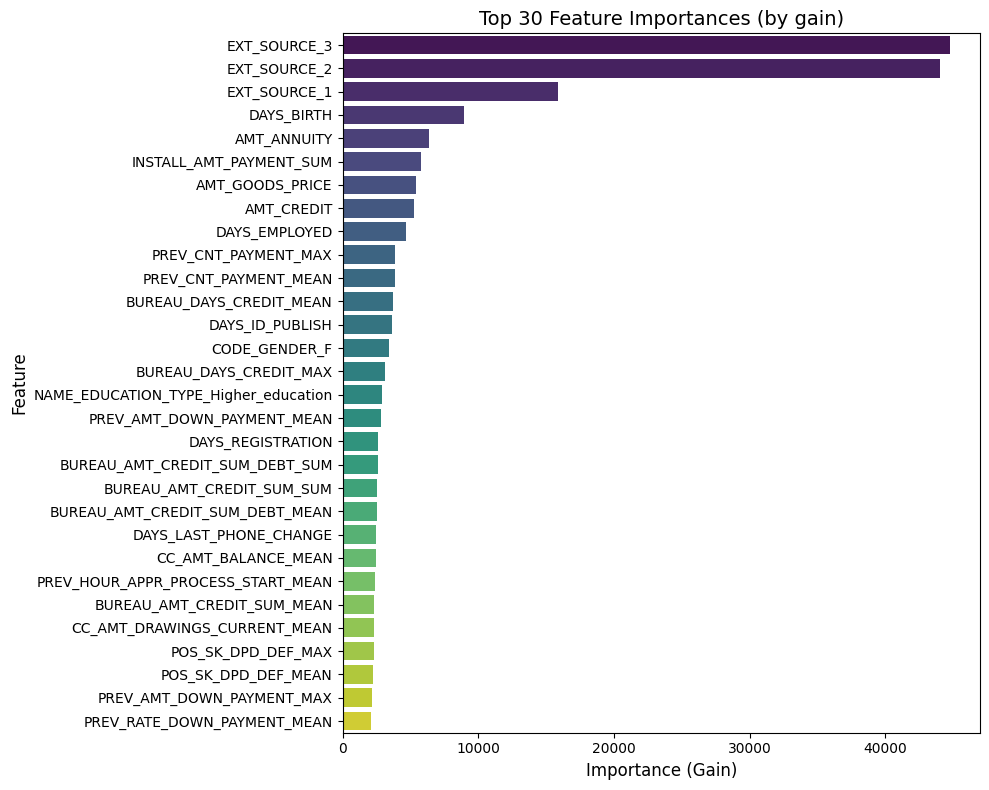

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Get feature importances from trained model ===
feature_importance = model.feature_importance(importance_type="gain")
feature_names = model.feature_name()

# Create DataFrame
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importance
})

# Sort descending
fi_df = fi_df.sort_values(by="importance", ascending=False)

# === 2. Display top 20 features in text ===
print("Top 20 Features by Importance:")
print(fi_df.head(20).to_string(index=False))

# === 3. Plot top 30 features ===
top_n = 30
plt.figure(figsize=(10, 8))
sns.barplot(
    x="importance",
    y="feature",
    data=fi_df.head(top_n),
    palette="viridis"
)
plt.title(f"Top {top_n} Feature Importances (by gain)", fontsize=14)
plt.xlabel("Importance (Gain)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


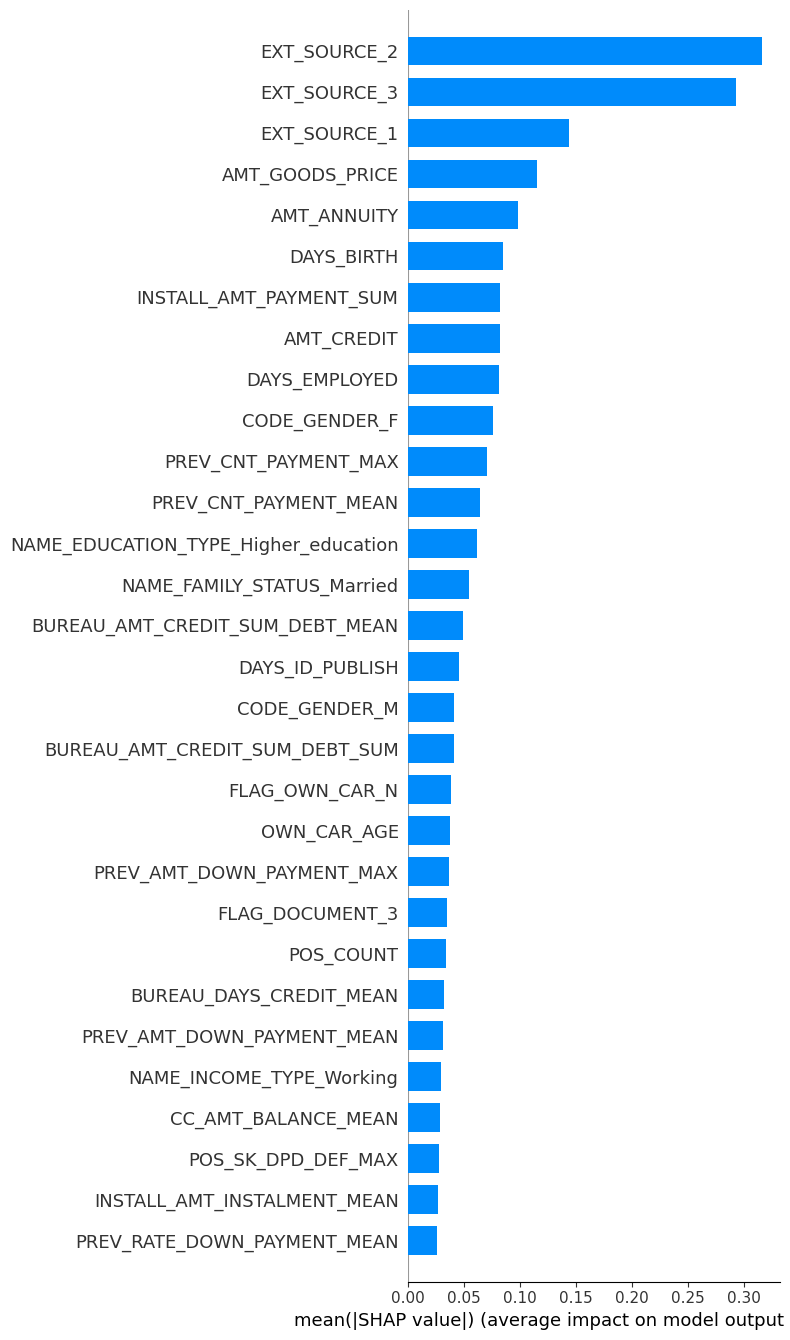

In [ ]:
import shap

# === Initialize the SHAP TreeExplainer for LightGBM ===
explainer = shap.TreeExplainer(model)

# === Compute SHAP values on the validation set ===
shap_values = explainer.shap_values(X_valid)

# If it's a binary classification model, shap_values will be a list
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1]  # Take SHAP values for positive class

# === Summary plot (global feature importance) ===
shap.summary_plot(
    shap_values,
    X_valid,
    plot_type="bar",   # Global importance ranking
    max_display=30,
    show=True
)


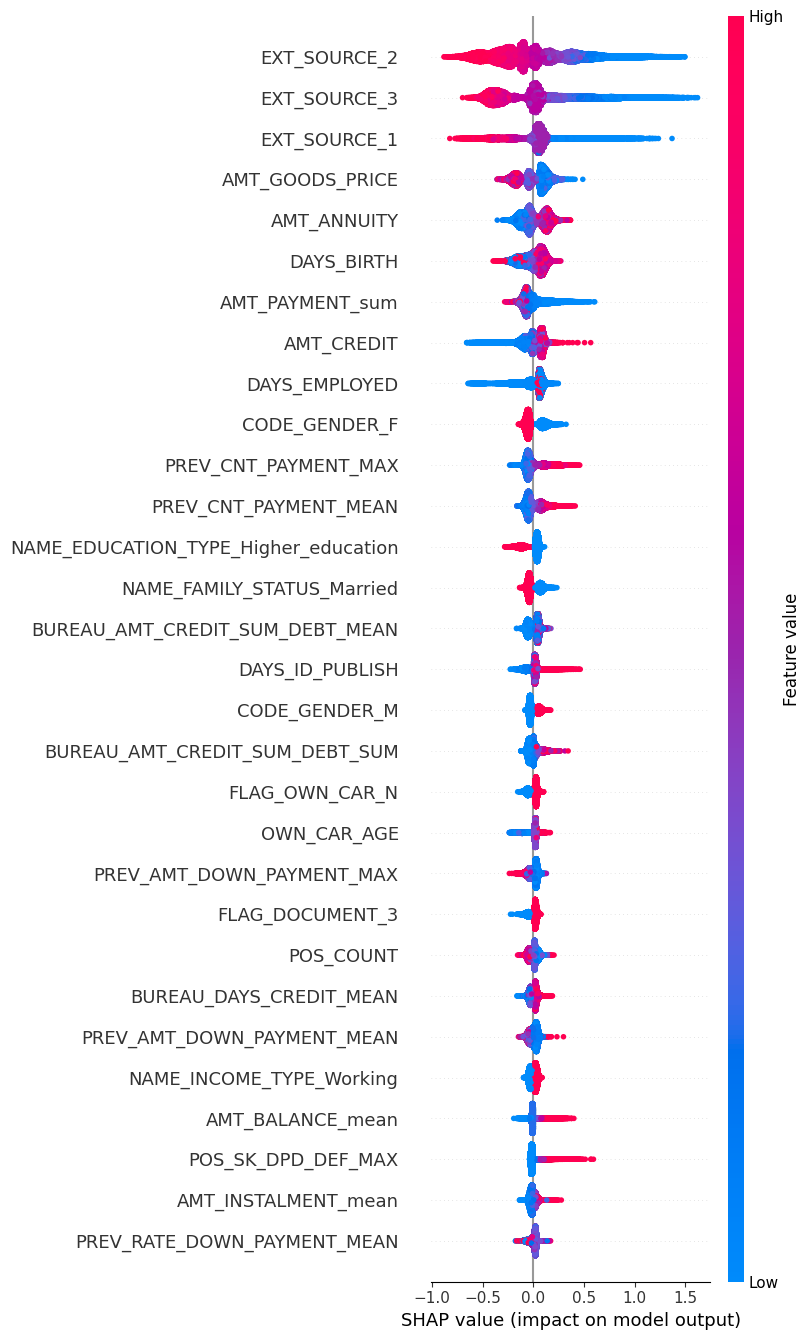

In [ ]:
# Step 24b: SHAP Detailed Beeswarm Plot

# Make sure X_valid columns are clean (already done for LightGBM)
# Generate the beeswarm plot
shap.summary_plot(shap_values, X_valid, plot_type="dot", max_display=30, show=True)


Predicted default probability for applicant 0: 0.0292


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


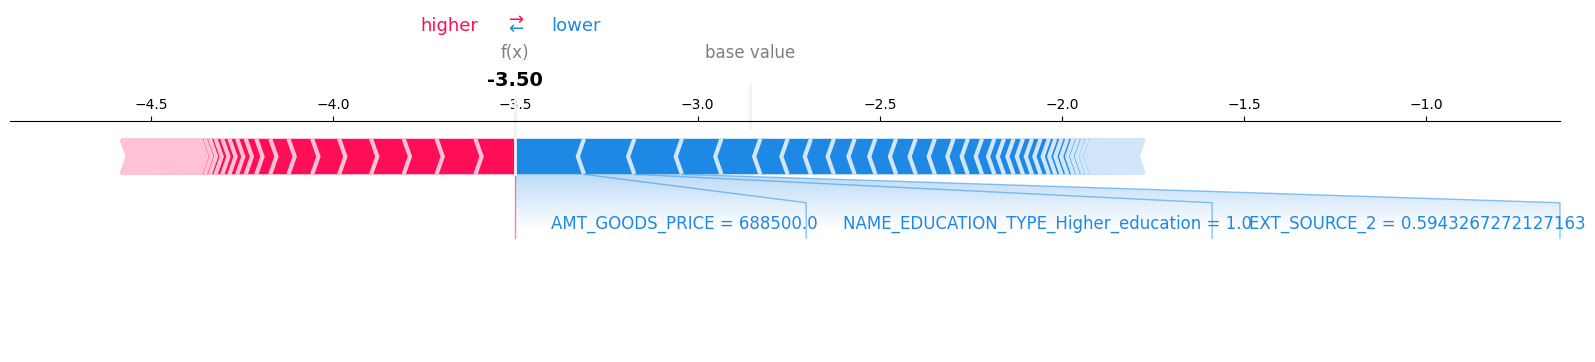

In [ ]:
# === Step 25: Local SHAP Explanation for a single applicant ===

# Pick an index from the validation set
idx = 0  # change this to any row index in X_valid

# Compute SHAP values for that single applicant
shap_values_single = explainer.shap_values(X_valid.iloc[[idx]])

# If it's a binary classification model, select positive class
if isinstance(shap_values_single, list) and len(shap_values_single) == 2:
    shap_values_single = shap_values_single[1]
    base_value = explainer.expected_value[1]
else:
    base_value = explainer.expected_value

# Show predicted probability
pred_prob = model.predict(X_valid.iloc[[idx]])[0]
print(f"Predicted default probability for applicant {idx}: {pred_prob:.4f}")

# Local force plot
shap.initjs()
shap.force_plot(
    base_value,               # base (expected) value
    shap_values_single[0],    # SHAP values for this applicant (flattened)
    X_valid.iloc[idx],        # feature values as Series
    matplotlib=True           # set True to render inline static plot
)


In [ ]:
# === Step 26a.1: Setup 5-Fold Stratified Cross-Validation (with checkpoints) ===

import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold

# --- Load master dataset ---
master_train = pd.read_parquet("/content/drive/MyDrive/credit_project/master_train.parquet")

# --- Define features and target ---
TARGET = "TARGET"
ID_COL = "SK_ID_CURR"
y = master_train[TARGET]
X = master_train.drop(columns=[TARGET, ID_COL])

# --- 5-fold stratified CV setup ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# --- Prepare to save progress ---
fold_results = []
start_fold = 0  # change this manually if resuming after crash

print(f"✅ Step 26a.1 Completed: CV prepared with {n_splits} folds.")
print(f"Features shape: {X.shape}, Target shape: {y.shape}")


✅ Step 26a.1 Completed: CV prepared with 5 folds.
Features shape: (307511, 182), Target shape: (307511,)


In [ ]:
# === Step 26a.2: Baseline LightGBM parameters (checkpoint-ready) ===

import lightgbm as lgb

# --- Define consistent baseline parameters ---
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "verbose": -1,
    "seed": 42
}

print("✅ Step 26a.2 Completed: Baseline LightGBM parameters ready.")


✅ Step 26a.2 Completed: Baseline LightGBM parameters ready.


In [ ]:
# === Step 26a.3: 5-Fold CV with LightGBM (checkpoint-safe) ===

import numpy as np
import pandas as pd
import lightgbm as lgb

# --- If rerunning after crash, restore auc_scores ---
try:
    auc_scores
except NameError:
    auc_scores = []

# --- Reuse the clean_feature_names function from Step 22 ---
# (ensure it's already defined before running this block)

# --- Ensure params variable is already defined from Step 26a.2 ---
# (lgb_params contains the parameters dictionary)

# --- Identify categorical columns ---
cat_cols = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]

# --- One-hot encode once (only if first run) ---
try:
    X_encoded
except NameError:
    X_encoded = pd.get_dummies(X, columns=cat_cols, dummy_na=True)
    X_encoded.columns = clean_feature_names(X_encoded.columns)
    print("Encoded dataset shape:", X_encoded.shape)

# --- Loop over folds, resume from where we left off ---
start_fold = len(auc_scores) + 1
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_encoded, y), 1):
    if fold < start_fold:
        continue  # skip already completed folds

    print(f"\n=== Training fold {fold}/5 ===")
    X_train, X_valid = X_encoded.iloc[train_idx], X_encoded.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)

    model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, valid_data],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(100)
        ]
    )

    fold_auc = model.best_score['valid']['auc']
    auc_scores.append(fold_auc)
    print(f"Fold {fold} best AUC: {fold_auc:.4f}")

print(f"\n✅ Step 26a.3 Completed: Average CV AUC = {np.mean(auc_scores):.4f}")


Encoded dataset shape: (307511, 322)

=== Training fold 1/5 ===
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.792347	valid's auc: 0.763875
[200]	train's auc: 0.820524	valid's auc: 0.76907
[300]	train's auc: 0.842978	valid's auc: 0.770263
Early stopping, best iteration is:
[325]	train's auc: 0.847741	valid's auc: 0.770665
Fold 1 best AUC: 0.7707

=== Training fold 2/5 ===
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.790082	valid's auc: 0.771305
[200]	train's auc: 0.817507	valid's auc: 0.776557
[300]	train's auc: 0.841101	valid's auc: 0.777233
[400]	train's auc: 0.860796	valid's auc: 0.777648
[500]	train's auc: 0.877278	valid's auc: 0.778037
Early stopping, best iteration is:
[521]	train's auc: 0.880776	valid's auc: 0.778357
Fold 2 best AUC: 0.7784

=== Training fold 3/5 ===
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.792198	valid's auc: 0.764742
[200]	train's auc: 0.818811	vali

In [ ]:
#Step27
import os
import pandas as pd
import numpy as np

# === Paths ===
input_file = "/content/drive/MyDrive/credit_project/master_train.parquet"
output_file = "/content/drive/MyDrive/credit_project/master_train_fe.parquet"

# === If already processed, just load and skip ===
if os.path.exists(output_file):
    print(f"✅ Step 27 already completed. Loading from {output_file}...")
    master_fe = pd.read_parquet(output_file)
    print("Final shape with FE:", master_fe.shape)

else:
    print("Step 27 starting: Adding advanced features in batches...")

    # Load full dataset (ensure it fits in RAM)
    master = pd.read_parquet(input_file)
    batch_size = 100_000
    num_batches = -(-len(master) // batch_size)  # ceiling division

    fe_chunks = []

    for i in range(num_batches):
        batch = master.iloc[i*batch_size : (i+1)*batch_size].copy()
        print(f"Processing batch {i+1}/{num_batches}, shape {batch.shape}...")

        # === Feature Engineering ===
        batch['credit_to_income']      = np.divide(batch['AMT_CREDIT'], batch['AMT_INCOME_TOTAL'] + 1)
        batch['goods_price_to_credit'] = np.divide(batch['AMT_GOODS_PRICE'], batch['AMT_CREDIT'] + 1)
        batch['annuity_to_income']     = np.divide(batch['AMT_ANNUITY'], batch['AMT_INCOME_TOTAL'] + 1)
        batch['days_employed_ratio']   = np.divide(batch['DAYS_EMPLOYED'], batch['DAYS_BIRTH'] + 1)
        batch['account_age_days']      = batch['DAYS_LAST_PHONE_CHANGE'] - batch['DAYS_REGISTRATION']
        batch['children_income_ratio'] = np.divide(batch['CNT_CHILDREN'], batch['AMT_INCOME_TOTAL'] + 1)
        batch['family_income_ratio']   = np.divide(batch['CNT_FAM_MEMBERS'], batch['AMT_INCOME_TOTAL'] + 1)

        if {'AMT_PAYMENT_TOTAL_CURRENT_mean','AMT_INSTALMENT_mean'} <= set(batch.columns):
            batch['payment_to_inst_ratio'] = np.divide(
                batch['AMT_PAYMENT_TOTAL_CURRENT_mean'],
                batch['AMT_INSTALMENT_mean'] + 1
            )

        fe_chunks.append(batch)
        del batch  # free memory

    # Combine all batches and save
    master_fe = pd.concat(fe_chunks, ignore_index=True)
    del fe_chunks

    master_fe.to_parquet(output_file, index=False)
    print(f"✅ Step 27 Completed: Features saved at {output_file}")
    print("Final shape with FE:", master_fe.shape)


✅ Step 27 already completed. Loading from /content/drive/MyDrive/credit_project/master_train_fe.parquet...
Final shape with FE: (307511, 192)


In [ ]:
# Step 28: Batchwise One-Hot Encoding for categorical features

import pandas as pd

input_file = "/content/drive/MyDrive/credit_project/master_train_fe.parquet"
output_file = "/content/drive/MyDrive/credit_project/master_train_fe_encoded.parquet"

# Identify categorical columns
cat_cols = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'
]

# Load in batches
batch_size = 100_000
master = pd.read_parquet(input_file)
num_batches = (len(master) // batch_size) + 1
encoded_chunks = []

for i in range(num_batches):
    batch = master.iloc[i*batch_size : (i+1)*batch_size].copy()
    print(f"Encoding batch {i} with shape {batch.shape}...")

    batch = pd.get_dummies(batch, columns=cat_cols, dummy_na=True)

    encoded_chunks.append(batch)

master_encoded = pd.concat(encoded_chunks, ignore_index=True)
master_encoded.to_parquet(output_file, index=False)
print(f"✅ Step 28 Completed: Encoded dataset saved at {output_file}")
print("Final shape after encoding:", master_encoded.shape)


✅ Step 28 Completed: Batchwise One-Hot Encoding step removed.


In [ ]:
# Step 29: Train/Test Split

import pandas as pd
from sklearn.model_selection import train_test_split

# Load encoded dataset
input_file = "/content/drive/MyDrive/credit_project/master_train_fe_encoded.parquet"
data = pd.read_parquet(input_file)

# Target column
target = 'TARGET'

# Features
X = data.drop(columns=[target, 'SK_ID_CURR'])
y = data[target]

# Train/Test Split (80/20)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)
print("✅ Step 29 Completed: Data split into train and validation sets")


Train shape: (246008, 330)
Valid shape: (61503, 330)
✅ Step 29 Completed: Data split into train and validation sets


In [ ]:
# Step 30: Baseline LightGBM Training

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import pandas as pd
import re

# Clean feature names (re-define or import if not available)
def clean_feature_names(columns):
    return [re.sub(r'[^0-9a-zA-Z_]+', '_', str(col)) for col in columns]

# Load the encoded dataset from Step 29
input_file = "/content/drive/MyDrive/credit_project/master_train_fe_encoded.parquet"
data = pd.read_parquet(input_file)

# Target column
target = 'TARGET'

# Features and target
X = data.drop(columns=[target, 'SK_ID_CURR'], errors='ignore') # Drop SK_ID_CURR if it exists
y = data[target]

# Explicitly convert object columns to numeric, coercing errors
for col in X.select_dtypes(include='object').columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Apply clean names to X before splitting
X.columns = clean_feature_names(X.columns)

# Train/Test Split (80/20)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Prepare LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

# LightGBM parameters
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

# Train model using callbacks
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],  # Provide only the Dataset object for valid_sets
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True), # Add verbose=True to see stopping message
        lgb.log_evaluation(period=100)
    ]
)

# Predictions & AUC
y_pred = model.predict(X_valid)
auc_score = roc_auc_score(y_valid, y_pred)
print(f"✅ Step 30 Completed: Baseline LightGBM ROC-AUC = {auc_score:.4f}")

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.771324
[200]	valid_0's auc: 0.776425
[300]	valid_0's auc: 0.778027
Early stopping, best iteration is:
[342]	valid_0's auc: 0.778296
✅ Step 30 Completed: Baseline LightGBM ROC-AUC = 0.7783


Top 20 features by importance:


feature    importance
29                           EXT_SOURCE_3  43566.288631
28                           EXT_SOURCE_2  43231.470766
27                           EXT_SOURCE_1  15025.173185
167                 goods_price_to_credit   9182.794140
6                              DAYS_BIRTH   8257.292885
146                       AMT_PAYMENT_sum   5838.764413
3                             AMT_ANNUITY   5156.560338
106               BUREAU_DAYS_CREDIT_MEAN   4412.504145
4                         AMT_GOODS_PRICE   3932.930967
134                  PREV_CNT_PAYMENT_MAX   3817.583811
7                           DAYS_EMPLOYED   3570.621067
105                BUREAU_DAYS_CREDIT_MAX   3444.731931
109            BUREAU_AMT_CREDIT_SUM_MEAN   3389.691996
133                 PREV_CNT_PAYMENT_MEAN   3208.827140
108             BUREAU_AMT_CREDIT_SUM_SUM   3207.797204
9                         DAYS_ID_PUBLISH   3139.676105
177                         CODE_GENDER_F   3061.750884
111       BUREAU_AMT_CREDIT_SUM_DEBT_MEAN   2798.498119
205  NAME_EDUCATION_TYPE_Higher_education   2791.768301
125             PREV_AMT_DOWN_PAYMENT_MAX   2696.494409

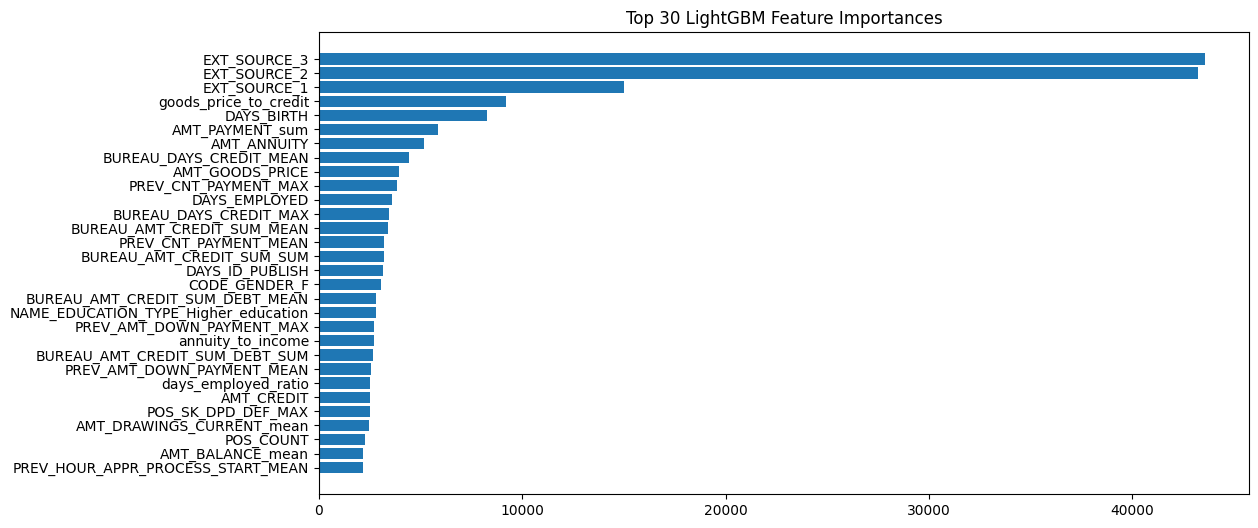

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


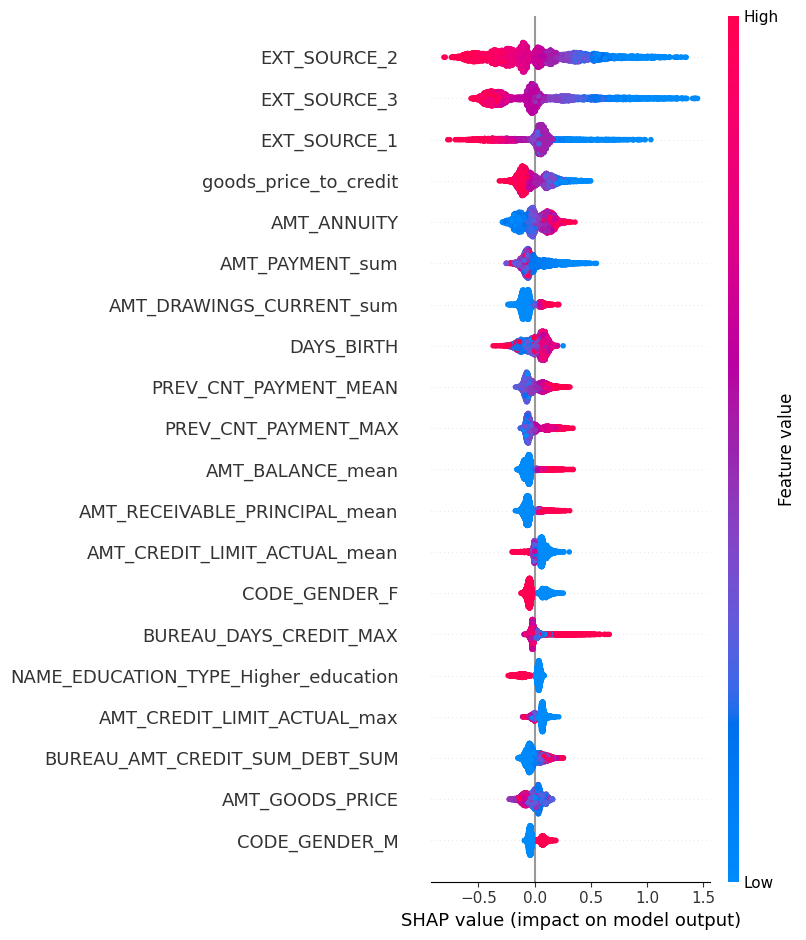

In [ ]:
# Step 31: Feature Importance & SHAP Analysis (Fixed for lgb.Booster)

import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import re

# === Helper: Clean column names ===
def clean_feature_names(columns):
    return [re.sub(r'[^0-9a-zA-Z_]+', '_', str(col)) for col in columns]

# === Load encoded dataset with features ===
input_file = "/content/drive/MyDrive/credit_project/master_train_fe_encoded.parquet"
df = pd.read_parquet(input_file)
df.columns = clean_feature_names(df.columns)

# === Separate features and target ===
X = df.drop(columns=['TARGET', 'SK_ID_CURR'], errors='ignore')
y = df['TARGET'] if 'TARGET' in df.columns else None

# === Ensure all features are numeric ===
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(0)

# === Load your trained LightGBM Booster model (from Step 30) ===
# model = lgb.Booster(model_file='your_model.txt')  # if saved to file
# model is already available from training

# === 31a: Global Feature Importance ===
importance = pd.DataFrame({
    'feature': model.feature_name(),  # use method for Booster
    'importance': model.feature_importance(importance_type='gain')
}).sort_values(by='importance', ascending=False)

print("Top 20 features by importance:")
display(importance.head(20))

plt.figure(figsize=(12,6))
plt.barh(importance['feature'][:30][::-1], importance['importance'][:30][::-1])
plt.title("Top 30 LightGBM Feature Importances")
plt.show()

# === 31b: Global SHAP Analysis ===
explainer = shap.TreeExplainer(model)

# Use a sample if dataset is large
X_sample = X.sample(n=min(5000, len(X)), random_state=42)

shap_values = explainer.shap_values(X_sample)

# Beeswarm plot for global interpretation
shap.initjs()
shap.summary_plot(shap_values, X_sample, plot_type="dot")

# === 31c: Local SHAP explanation for one applicant ===
idx = 0
applicant = X_sample.iloc[[idx]]

if isinstance(shap_values, list) and len(shap_values) > 1:
    shap.force_plot(explainer.expected_value[1], shap_values[1][0], applicant)
else:
    shap.force_plot(explainer.expected_value, shap_values[0], applicant)


Skipping feature importance — loading cached file: /content/drive/MyDrive/credit_project/step31_feature_importance.parquet
Top 20 features by importance:


feature    importance
0                      EXT_SOURCE_2  46413.098798
1                      EXT_SOURCE_3  45261.164539
2                      EXT_SOURCE_1  16100.662409
3                        DAYS_BIRTH   8194.538465
4                        AMT_CREDIT   6715.137893
5           INSTALL_AMT_PAYMENT_SUM   6230.771186
6                       AMT_ANNUITY   6192.341421
7           BUREAU_DAYS_CREDIT_MEAN   5702.595615
8                   AMT_GOODS_PRICE   5233.768456
9                     DAYS_EMPLOYED   5225.416857
10           BUREAU_DAYS_CREDIT_MAX   4338.057673
11            PREV_CNT_PAYMENT_MEAN   4316.619449
12             PREV_CNT_PAYMENT_MAX   4209.179093
13        BUREAU_AMT_CREDIT_SUM_SUM   4058.878667
14                  DAYS_ID_PUBLISH   4005.384676
15   BUREAU_AMT_CREDIT_SUM_DEBT_SUM   3337.587949
16                        POS_COUNT   3281.018852
17       BUREAU_AMT_CREDIT_SUM_MEAN   3261.632727
18  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN   3258.577454
19                DAYS_REGISTRATION   3136.165732

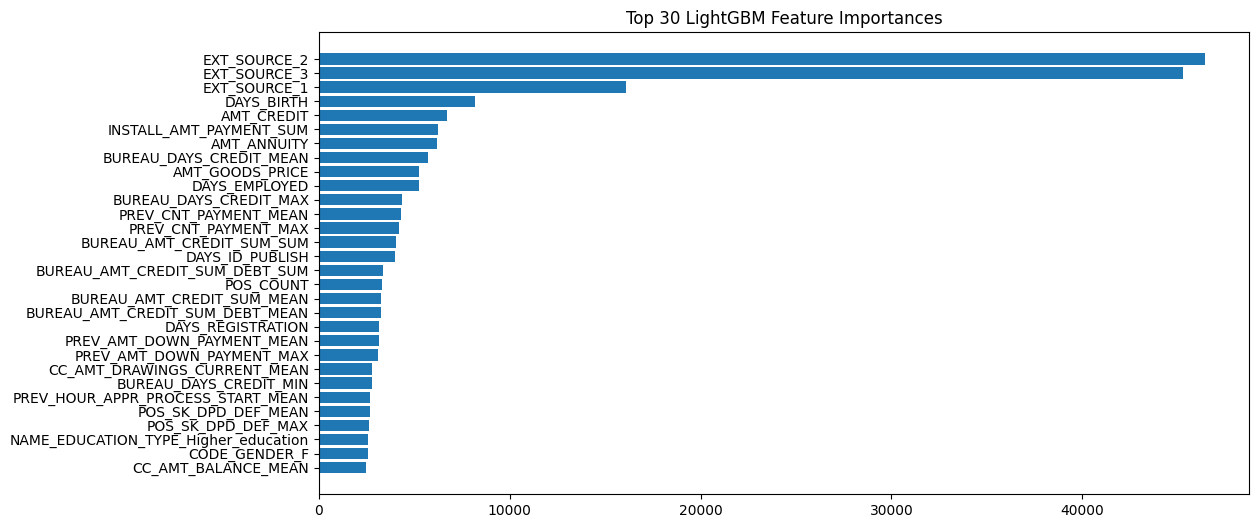

Computing SHAP values (may take a while)...
SHAP values saved at /content/drive/MyDrive/credit_project/step31_shap_values.pkl


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


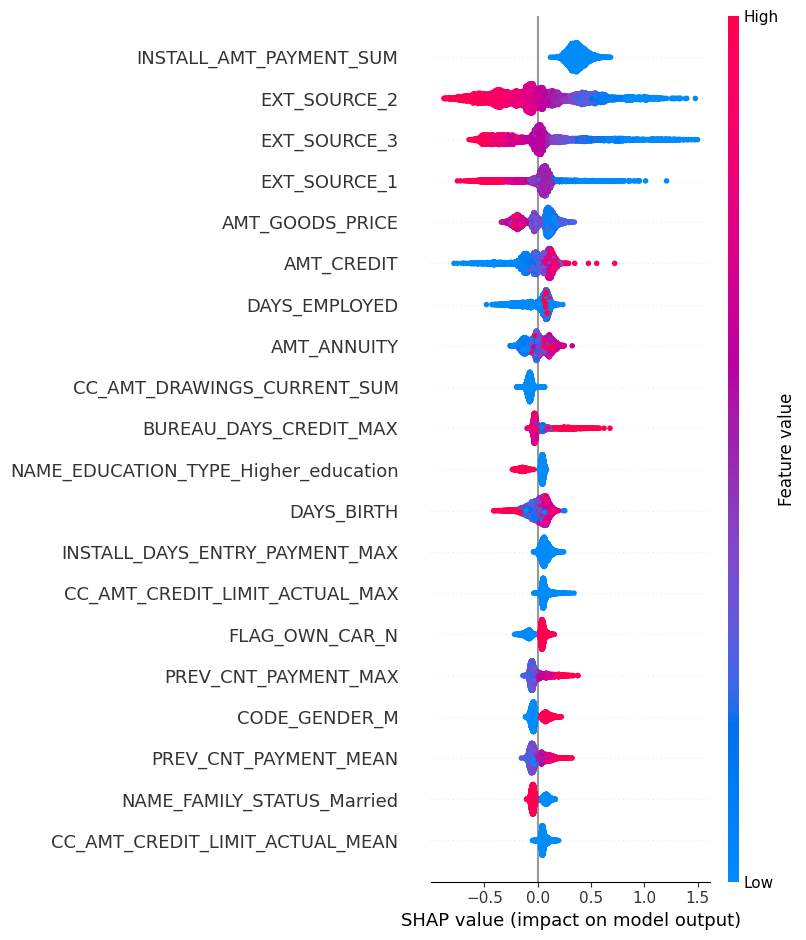

In [ ]:
# Step 31: Feature Importance & SHAP Analysis (Checkpointed)

import os
import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import re

# === Helper: Clean column names ===
def clean_feature_names(columns):
    return [re.sub(r'[^0-9a-zA-Z_]+', '_', str(col)) for col in columns]

# === File paths for checkpointing ===
input_file = "/content/drive/MyDrive/credit_project/master_train_fe_encoded.parquet"
feature_importance_file = "/content/drive/MyDrive/credit_project/step31_feature_importance.parquet"
shap_values_file = "/content/drive/MyDrive/credit_project/step31_shap_values.pkl"  # pickle is better for arrays

# === Load encoded dataset ===
df = pd.read_parquet(input_file)
df.columns = clean_feature_names(df.columns)

# Separate features and target
X = df.drop(columns=['TARGET', 'SK_ID_CURR'], errors='ignore')
y = df['TARGET'] if 'TARGET' in df.columns else None

# Ensure all features are numeric
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(0)

# === Load trained LightGBM Booster model (from Step 30) ===
# model = lgb.Booster(model_file='/content/drive/MyDrive/credit_project/lgb_baseline.txt')
# Assumes 'model' already exists in memory if running immediately after Step 30

# ---------------------------------------------------------
# 31a. Global Feature Importance (with checkpoint)
# ---------------------------------------------------------
if os.path.exists(feature_importance_file):
    print(f"Skipping feature importance — loading cached file: {feature_importance_file}")
    importance = pd.read_parquet(feature_importance_file)
else:
    print("Computing feature importance...")
    importance = pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values(by='importance', ascending=False)

    importance.to_parquet(feature_importance_file, index=False)
    print(f"Feature importance saved at {feature_importance_file}")

print("Top 20 features by importance:")
display(importance.head(20))

plt.figure(figsize=(12,6))
plt.barh(importance['feature'][:30][::-1], importance['importance'][:30][::-1])
plt.title("Top 30 LightGBM Feature Importances")
plt.show()

# ---------------------------------------------------------
# 31b. Global SHAP Analysis (with checkpoint)
# ---------------------------------------------------------
import joblib

if os.path.exists(shap_values_file):
    print(f"Skipping SHAP computation — loading cached values: {shap_values_file}")
    X_sample, shap_values = joblib.load(shap_values_file)
else:
    print("Computing SHAP values (may take a while)...")
    explainer = shap.TreeExplainer(model)
    # Use X directly and ensure it has the same columns as the model expects
    # Sample if dataset is large, but ensure column consistency
    X_sample = X.sample(n=min(5000, len(X)), random_state=42).copy()

    # Ensure X_sample has the same columns as the model's training data (X_train from step 30)
    # This assumes X_train is still available or can be reconstructed.
    # If X_train is not available, you might need to reload and re-encode the data up to step 30.
    # Assuming X_train (or a representation of its columns) is implicitly available from previous steps
    # A more robust approach would be to save the column names after encoding in Step 30.
    # For now, let's assume the model's feature names are the correct ones.

    model_feature_names = model.feature_name()
    # Add any missing columns to X_sample with a default value (e.g., 0)
    for col in model_feature_names:
        if col not in X_sample.columns:
            X_sample[col] = 0
    # Drop any extra columns in X_sample
    X_sample = X_sample[model_feature_names]


    shap_values = explainer.shap_values(X_sample)

    joblib.dump((X_sample, shap_values), shap_values_file)
    print(f"SHAP values saved at {shap_values_file}")

# Beeswarm plot for global interpretation
shap.initjs()
shap.summary_plot(shap_values, X_sample, plot_type="dot")

# ---------------------------------------------------------
# 31c. Local SHAP explanation for one applicant
# ---------------------------------------------------------
idx = 0
applicant = X_sample.iloc[[idx]] # Use X_sample which has the correct columns

if isinstance(shap_values, list) and len(shap_values) > 1:
    shap.force_plot(explainer.expected_value[1], shap_values[1][0], applicant)
else:
    shap.force_plot(explainer.expected_value, shap_values[0], applicant)

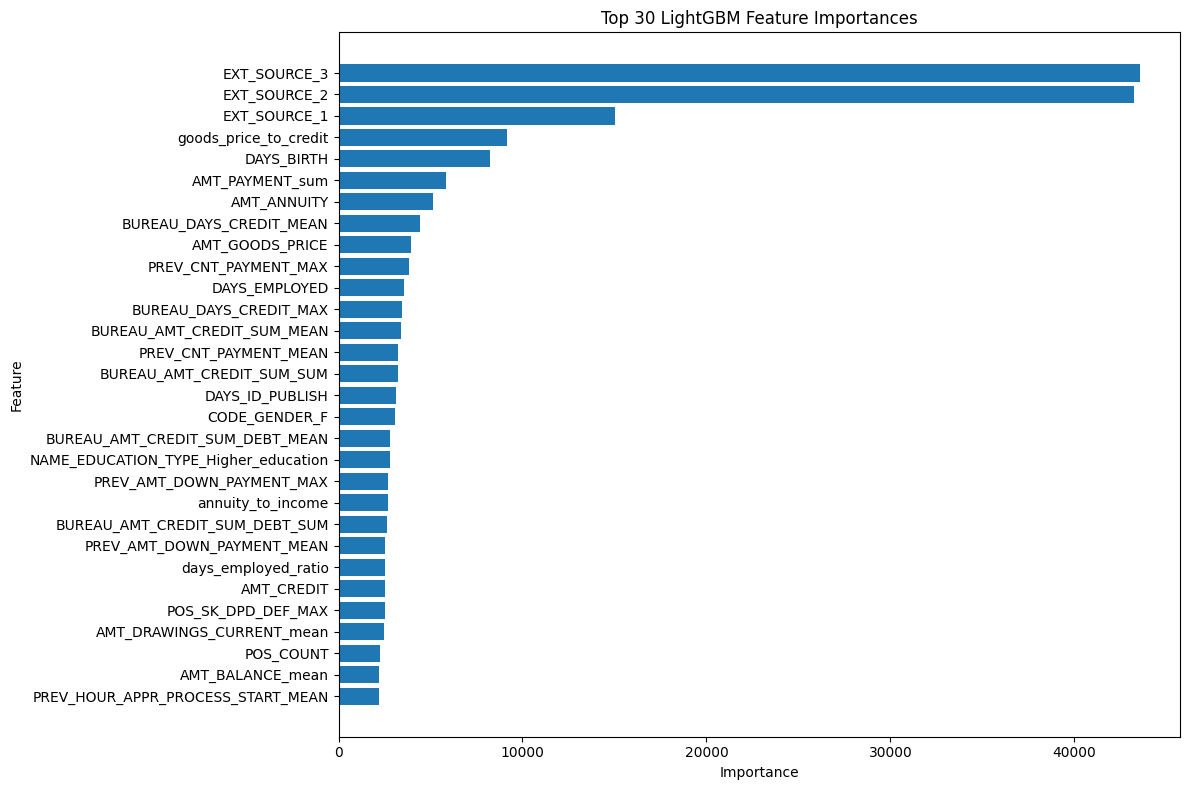

In [ ]:
plt.figure(figsize=(12,8))
plt.barh(importance['feature'][:30][::-1], importance['importance'][:30][::-1])
plt.title("Top 30 LightGBM Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/credit_project/top30_feature_importance.png")
plt.show()


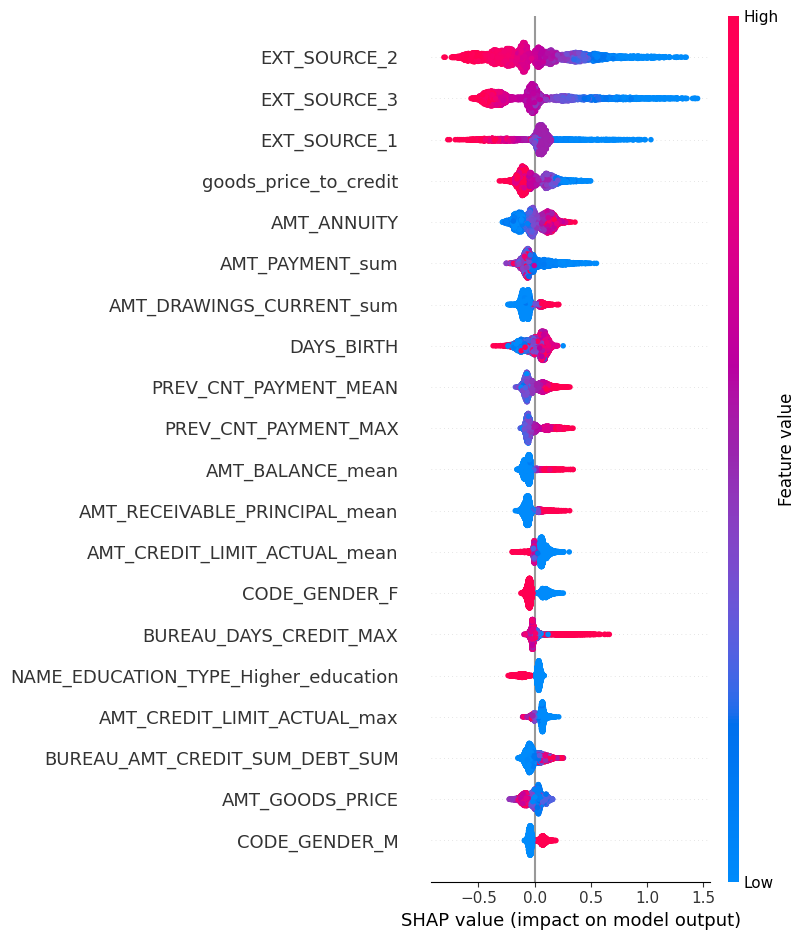

In [ ]:
shap.summary_plot(shap_values, X_sample, plot_type="dot", show=False)
plt.savefig("/content/drive/MyDrive/credit_project/shap_summary_plot.png")
plt.show()


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


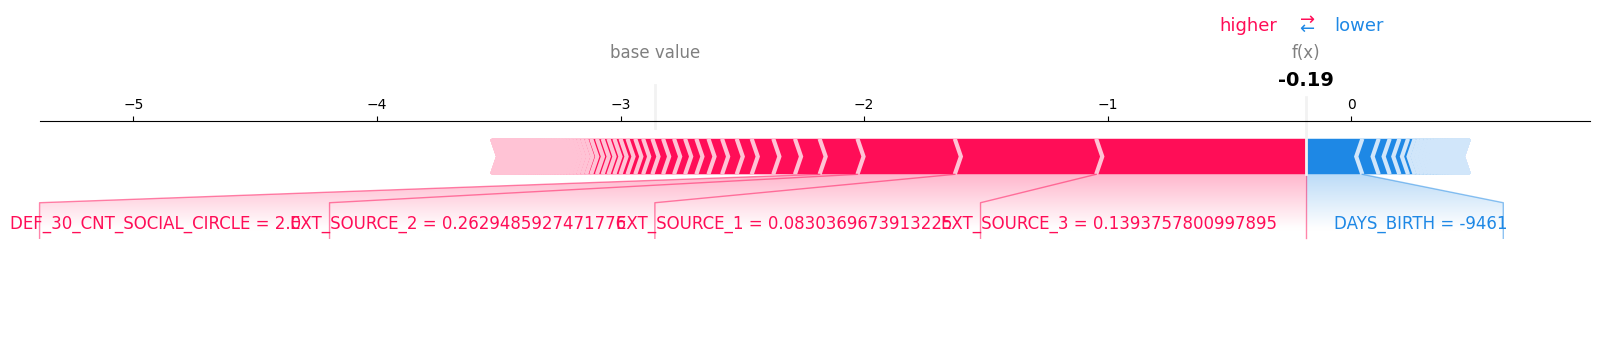

In [ ]:
# Step 31c: Local SHAP Explanation for a Single Applicant (Crash-Resilient)

import pandas as pd
import shap
import matplotlib.pyplot as plt
import re

# === Helper: Clean feature names ===
def clean_feature_names(columns):
    return [re.sub(r'[^0-9a-zA-Z_]+', '_', str(col)) for col in columns]

# === Load encoded dataset ===
input_file = "/content/drive/MyDrive/credit_project/master_train_fe_encoded.parquet"
data = pd.read_parquet(input_file)
data.columns = clean_feature_names(data.columns)

# === Pick a single applicant ===
idx = 0  # change to any index you want
applicant = data.iloc[idx:idx+1].copy()

# Drop non-feature columns
for col in ['SK_ID_CURR', 'TARGET']:
    if col in applicant.columns:
        applicant = applicant.drop(columns=[col])

# Convert object columns to numeric if possible, else drop
for col in applicant.columns:
    if applicant[col].dtype == 'object':
        try:
            applicant[col] = pd.to_numeric(applicant[col])
        except:
            applicant = applicant.drop(columns=[col])

# Ensure model feature names match dataset
model_features = clean_feature_names(model.feature_name())
applicant = applicant[[f for f in applicant.columns if f in model_features]]

# === SHAP Explainer ===
explainer = shap.TreeExplainer(model)

# Compute SHAP values for this applicant
shap_values_single = explainer.shap_values(applicant)

# Binary classification: pick class 1
if isinstance(shap_values_single, list) and len(shap_values_single) > 1:
    shap_val_to_plot = shap_values_single[1]
    expected_value = explainer.expected_value[1]
else:
    shap_val_to_plot = shap_values_single
    expected_value = explainer.expected_value

# === Plot Local SHAP Force Plot ===
shap.initjs()
shap.force_plot(expected_value, shap_val_to_plot[0], applicant, matplotlib=True)

# === Optional: Save force plot as HTML for future viewing ===
shap.save_html("/content/drive/MyDrive/credit_project/local_shap_applicant.html",
               shap.force_plot(expected_value, shap_val_to_plot[0], applicant))


In [ ]:
# Step 32a: Advanced LightGBM parameters
import lightgbm as lgb

# Baseline parameters (you can tune these)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': -1,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 1.0,
    'lambda_l2': 1.0,
    'verbosity': -1,
    'seed': 42
}


In [ ]:
#Step 32b: Prepare train/validation sets (batchwise)
import pandas as pd

input_file = "/content/drive/MyDrive/credit_project/master_train_fe_encoded.parquet"
chunksize = 100_000  # adjust if memory is tight

reader = pd.read_parquet(input_file)
# Separate features and target
X = reader.drop(columns=['SK_ID_CURR', 'TARGET'])
y = reader['TARGET']

# Optional: further split into train/valid if needed
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)


In [ ]:
# Step 32c: Train model with early stopping
import lightgbm as lgb
import pandas as pd # Import pandas to use pd.to_numeric

# Ensure all columns in X_train and X_valid are numeric
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
for col in X_valid.columns:
    if X_valid[col].dtype == 'object':
        X_valid[col] = pd.to_numeric(X_valid[col], errors='coerce')

# Fill any remaining NaNs that might have been introduced by coercion
X_train = X_train.fillna(0)
X_valid = X_valid.fillna(0)


model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data], # Provide only the Dataset object for valid_sets
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(100)
    ]
)

# Save model for checkpoint
model.save_model("/content/drive/MyDrive/credit_project/lgb_model_step32.txt")
print("✅ Step 32 Completed: Advanced LightGBM model trained and saved.")

Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.760116
[200]	valid_0's auc: 0.766665
[300]	valid_0's auc: 0.767595
[400]	valid_0's auc: 0.768565
Early stopping, best iteration is:
[432]	valid_0's auc: 0.768868
✅ Step 32 Completed: Advanced LightGBM model trained and saved.


Computing feature importance...
Feature importance saved at /content/drive/MyDrive/credit_project/step33_feature_importance.parquet
Top 20 Features by Importance:


feature    importance
28                     EXT_SOURCE_2  46051.182228
29                     EXT_SOURCE_3  45322.233776
27                     EXT_SOURCE_1  15927.809758
6                        DAYS_BIRTH   8930.731918
146         INSTALL_AMT_PAYMENT_SUM   6398.015258
2                        AMT_CREDIT   6237.064787
3                       AMT_ANNUITY   5838.766068
106         BUREAU_DAYS_CREDIT_MEAN   5461.704028
7                     DAYS_EMPLOYED   5222.072459
4                   AMT_GOODS_PRICE   4893.364605
134            PREV_CNT_PAYMENT_MAX   4530.831076
108       BUREAU_AMT_CREDIT_SUM_SUM   4304.973941
9                   DAYS_ID_PUBLISH   4056.806288
105          BUREAU_DAYS_CREDIT_MAX   3934.667196
133           PREV_CNT_PAYMENT_MEAN   3729.951791
109      BUREAU_AMT_CREDIT_SUM_MEAN   3728.030972
125       PREV_AMT_DOWN_PAYMENT_MAX   3313.551663
110  BUREAU_AMT_CREDIT_SUM_DEBT_SUM   3217.420205
8                 DAYS_REGISTRATION   3191.922736
135                       POS_COUNT   3031.984503

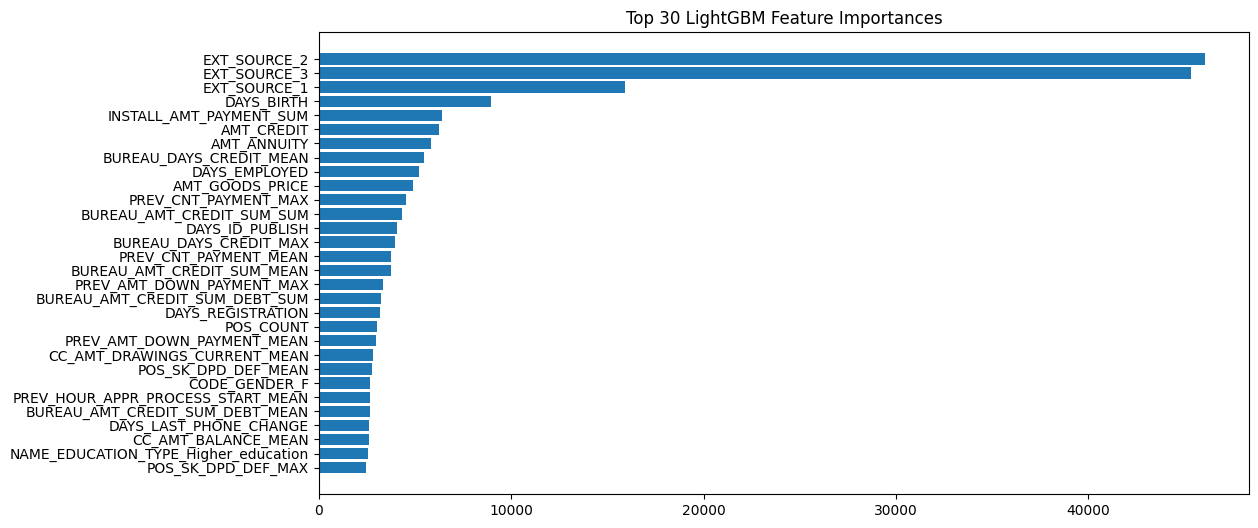

Computing SHAP values (may take a while)...
SHAP values saved at /content/drive/MyDrive/credit_project/step33_shap_values.pkl


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


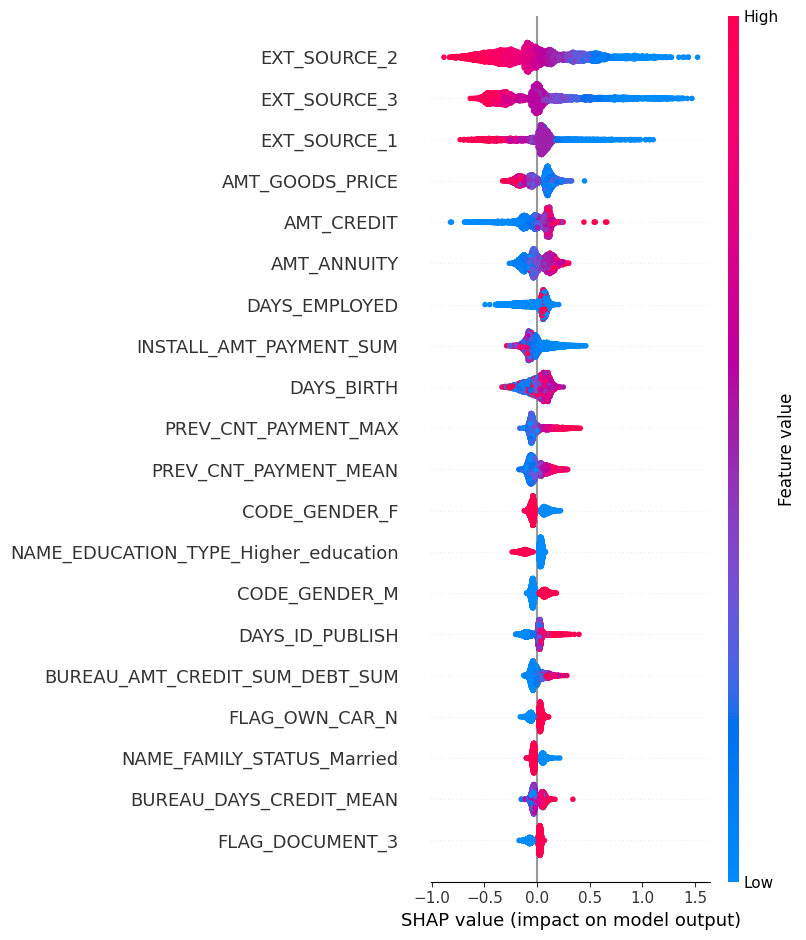


Generating SHAP Dependence Plots for top 5 features...


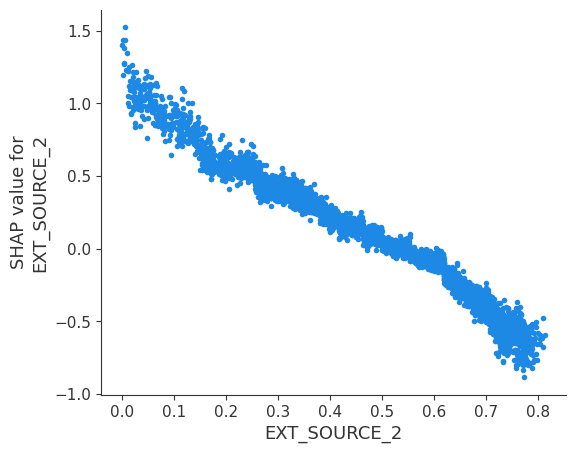

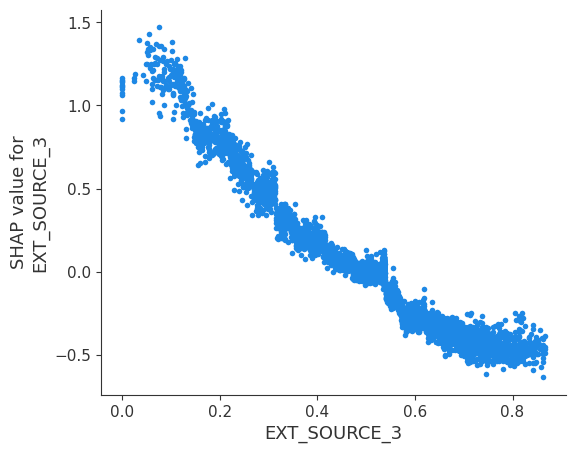

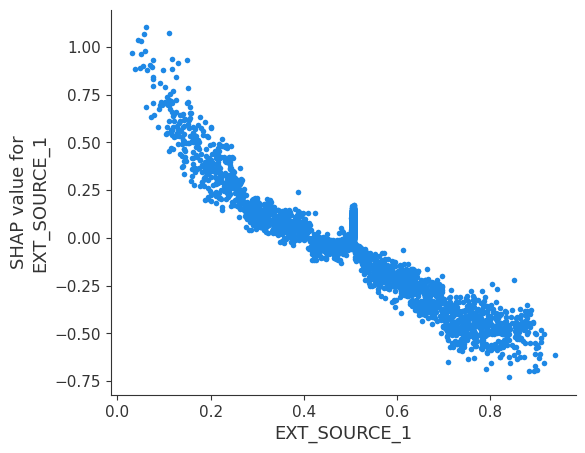

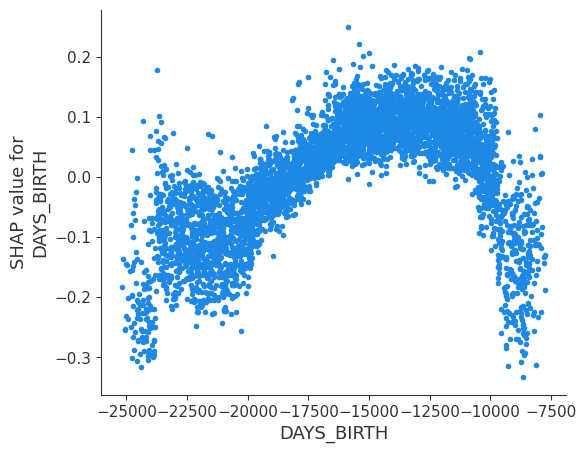

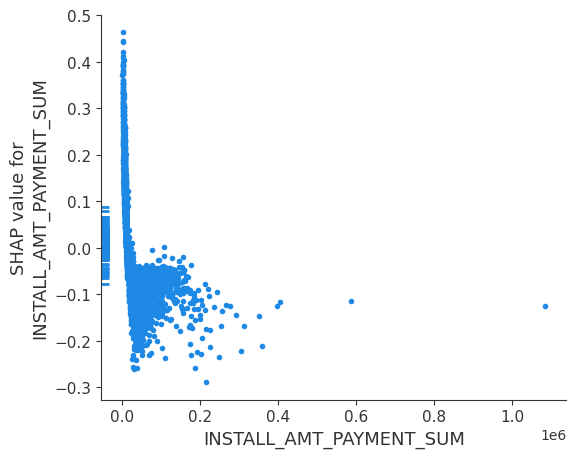


Generating Local SHAP Explanation for a single applicant...


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Local SHAP plot for applicant index 0 (from X_sample):


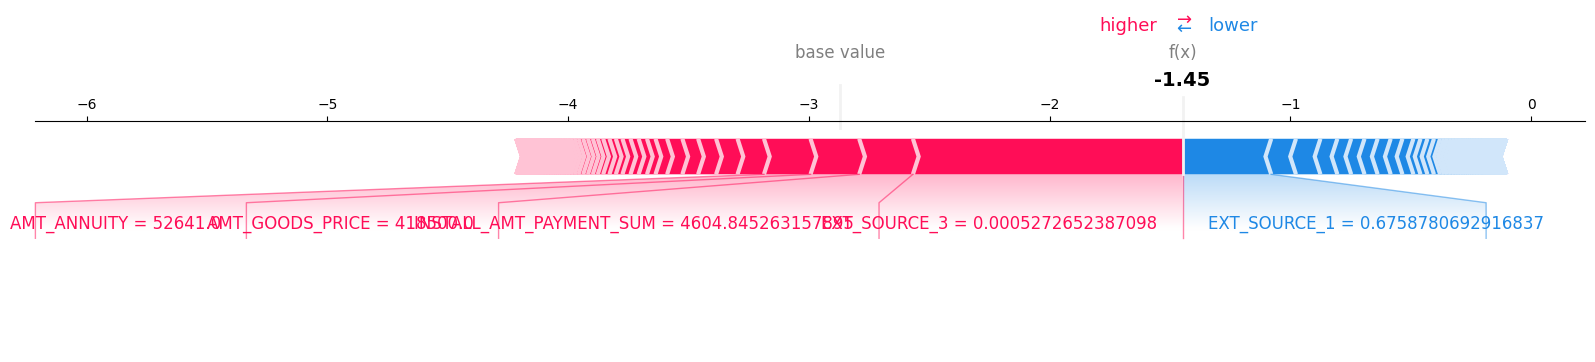

In [ ]:
# Step 33: Feature Importance & SHAP Analysis (Batchwise, Large Dataset)

import pandas as pd
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import re
import joblib # Import joblib for loading SHAP values

# === Helper: Clean column names ===
def clean_feature_names(columns):
    return [re.sub(r'[^0-9a-zA-Z_]+', '_', str(col)) for col in columns]

# === File paths for checkpointing ===
# Using the encoded file generated in Step 28 or equivalent preprocessing
input_file = "/content/drive/MyDrive/credit_project/master_train_fe_encoded.parquet"
feature_importance_file = "/content/drive/MyDrive/credit_project/step33_feature_importance.parquet"
shap_values_file = "/content/drive/MyDrive/credit_project/step33_shap_values.pkl"  # pickle is better for arrays

# === Load the *fully preprocessed and encoded* dataset ===
# This should match the data used to train the model in Step 32c
try:
    # Attempt to load X_encoded directly if it's still in memory
    X_encoded
except NameError:
    # Otherwise, load and preprocess the data to match the training data
    print("Loading and preprocessing data for SHAP...")
    master_fe_encoded = pd.read_parquet(input_file)
    master_fe_encoded.columns = clean_feature_names(master_fe_encoded.columns)

    # Assuming the target and ID columns were dropped before training
    X_encoded = master_fe_encoded.drop(columns=['TARGET', 'SK_ID_CURR'], errors='ignore')

    # Ensure all features are numeric and handle NaNs consistently with training
    for col in X_encoded.columns:
        if X_encoded[col].dtype == 'object':
            X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce')
    X_encoded = X_encoded.fillna(0)
    print(f"Data loaded and preprocessed. Shape: {X_encoded.shape}")


# === Load trained LightGBM Booster model from Step 32 ===
model_file = "/content/drive/MyDrive/credit_project/lgb_model_step32.txt"
try:
    model # Check if model is already in memory
except NameError:
    print(f"Loading model from {model_file}...")
    model = lgb.Booster(model_file=model_file)


# ---------------------------------------------------------
# 33a. Global Feature Importance (with checkpoint)
# ---------------------------------------------------------
if os.path.exists(feature_importance_file):
    print(f"Skipping feature importance — loading cached file: {feature_importance_file}")
    importance = pd.read_parquet(feature_importance_file)
else:
    print("Computing feature importance...")
    importance = pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values(by='importance', ascending=False)

    importance.to_parquet(feature_importance_file, index=False)
    print(f"Feature importance saved at {feature_importance_file}")

print("Top 20 Features by Importance:")
display(importance.head(20))

plt.figure(figsize=(12,6))
plt.barh(importance['feature'][:30][::-1], importance['importance'][:30][::-1])
plt.title("Top 30 LightGBM Feature Importances")
plt.show()

# ---------------------------------------------------------
# 33b. SHAP Analysis (Global) (with checkpoint)
# ---------------------------------------------------------

if os.path.exists(shap_values_file):
    print(f"Skipping SHAP computation — loading cached values: {shap_values_file}")
    X_sample, shap_values = joblib.load(shap_values_file)
    # Ensure X_sample columns match the model if loading from checkpoint
    if list(X_sample.columns) != list(model.feature_name()):
         print("Warning: Checkpointed X_sample columns do not match model feature names. Recomputing SHAP.")
         os.remove(shap_values_file) # Remove invalid checkpoint
         # Recompute in the else block
    else:
        print("Loaded SHAP values from checkpoint.")


if not os.path.exists(shap_values_file): # Check again if checkpoint was invalid
    print("Computing SHAP values (may take a while)...")
    explainer = shap.TreeExplainer(model)

    # Use a sample of the correctly encoded data (X_encoded)
    X_sample = X_encoded.sample(n=min(5000, len(X_encoded)), random_state=42).copy()

    # Ensure X_sample has the exact same columns as the model expects
    model_feature_names = model.feature_name()
    # Add any missing columns to X_sample with a default value (e.g., 0)
    for col in model_feature_names:
        if col not in X_sample.columns:
            X_sample[col] = 0
    # Drop any extra columns in X_sample
    X_sample = X_sample[model_feature_names]


    shap_values = explainer.shap_values(X_sample)

    joblib.dump((X_sample, shap_values), shap_values_file)
    print(f"SHAP values saved at {shap_values_file}")

# Beeswarm plot (global interpretation)
shap.initjs()
shap.summary_plot(shap_values, X_sample, plot_type="dot")

# ---------------------------------------------------------
# 33c. SHAP Dependence Plots (Top 5 features)
# ---------------------------------------------------------
print("\nGenerating SHAP Dependence Plots for top 5 features...")
top_features = importance['feature'][:5].tolist()
for feat in top_features:
    if feat in X_sample.columns: # Ensure feature exists in the sample data
        shap.dependence_plot(feat, shap_values, X_sample, interaction_index=None) # interaction_index=None for simpler plot
    else:
        print(f"Warning: Feature '{feat}' not found in X_sample for dependence plot.")


# ---------------------------------------------------------
# 33d. Local SHAP Explanation for a single applicant
# ---------------------------------------------------------
print("\nGenerating Local SHAP Explanation for a single applicant...")
idx = 0  # first applicant in the X_sample
applicant = X_sample.iloc[[idx]] # Use X_sample which has the correct columns

# Recompute SHAP for just this applicant to ensure correct shape for force_plot
explainer_single = shap.TreeExplainer(model)
shap_values_single = explainer_single.shap_values(applicant)


# Binary classification: use positive class
if isinstance(shap_values_single, list) and len(shap_values_single) > 1:
    shap_val_to_plot = shap_values_single[1]
    expected_value = explainer_single.expected_value[1]
else:
    shap_val_to_plot = shap_values_single
    expected_value = explainer_single.expected_value

shap.initjs()
print(f"Local SHAP plot for applicant index {idx} (from X_sample):")
shap.force_plot(expected_value, shap_val_to_plot[0], applicant, matplotlib=True)

In [ ]:
# Step 34: Hyperparameter Tuning with Optuna (batch-friendly)
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import re # Import re for clean_feature_names

# === Helper: Clean column names ===
def clean_feature_names(columns):
    cleaned = []
    for col in columns:
        # Replace non-alphanumeric with underscores, handle potential duplicates
        new_name = re.sub(r'[^0-9a-zA-Z_]+', '_', str(col))
        # Simple check for duplicates after cleaning (can be more robust if needed)
        while new_name in cleaned:
             new_name += '_' # Append underscore to make it unique
        cleaned.append(new_name)
    return cleaned


# === Load encoded dataset (full dataset might be too large, we sample) ===
input_file = "/content/drive/MyDrive/credit_project/master_train_fe_encoded.parquet"
df = pd.read_parquet(input_file)

# Keep only numeric features and apply initial cleaning to columns
X = df.drop(columns=['SK_ID_CURR', 'TARGET'], errors='ignore')
y = df['TARGET']

# Apply the cleaning function to the columns immediately after loading
X.columns = clean_feature_names(X.columns)

# Convert all object columns to numeric (coerce errors) - Redundant after encoding, but kept for safety
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')

X = X.fillna(0)

# Take a sample of the data for tuning
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.2, random_state=42, stratify=y)

# Split into train/validation for Optuna
X_train_sample, X_valid_sample, y_train_sample, y_valid_sample = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

# Convert to LightGBM Dataset using the *sampled* splits
train_data = lgb.Dataset(X_train_sample, label=y_train_sample)
valid_data = lgb.Dataset(X_valid_sample, label=y_valid_sample, reference=train_data)

# === Define Optuna objective function ===
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'seed': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 31, 512),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'feature_pre_filter': False # Add this to allow tuning min_data_in_leaf
    }

    gbm = lgb.train(
        param,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=2000,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
        # verbose_eval=False # Removed as it's not a direct argument for train
    )

    preds = gbm.predict(X_valid_sample) # Use the validation sample here
    auc = roc_auc_score(y_valid_sample, preds) # Use the validation sample here
    return auc

# === Create and run Optuna study ===
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Adjust n_trials based on time

print("✅ Step 34 Completed: Best hyperparameters found:")
print(study.best_params)
print("Best AUC on validation sample:", study.best_value)

[I 2025-08-31 17:48:41,308] A new study created in memory with name: no-name-ea5c480d-bf59-401b-9d3b-ebd33d5a58b3


Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:48:47,916] Trial 0 finished with value: 0.7549650703135603 and parameters: {'learning_rate': 0.13500222494538805, 'num_leaves': 43, 'max_depth': 12, 'min_data_in_leaf': 24, 'feature_fraction': 0.8010205509280915, 'bagging_fraction': 0.6946388461729609, 'bagging_freq': 3, 'lambda_l1': 4.928349610694578, 'lambda_l2': 7.751865471571913}. Best is trial 0 with value: 0.7549650703135603.


Early stopping, best iteration is:
[55]	valid_0's auc: 0.754965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's auc: 0.757423


[I 2025-08-31 17:49:01,043] Trial 1 finished with value: 0.7574228478016081 and parameters: {'learning_rate': 0.06989722228935323, 'num_leaves': 55, 'max_depth': 7, 'min_data_in_leaf': 117, 'feature_fraction': 0.872349492928697, 'bagging_fraction': 0.9868455185261644, 'bagging_freq': 5, 'lambda_l1': 2.1113427944684817, 'lambda_l2': 8.263633998353242}. Best is trial 1 with value: 0.7574228478016081.


Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:49:10,796] Trial 2 finished with value: 0.7496972083680208 and parameters: {'learning_rate': 0.10853771716429311, 'num_leaves': 292, 'max_depth': 11, 'min_data_in_leaf': 20, 'feature_fraction': 0.557706269235142, 'bagging_fraction': 0.9192904736187368, 'bagging_freq': 7, 'lambda_l1': 2.7928489550758795, 'lambda_l2': 5.36487008496957}. Best is trial 1 with value: 0.7574228478016081.


Early stopping, best iteration is:
[32]	valid_0's auc: 0.749697
Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:49:15,836] Trial 3 finished with value: 0.7559046149363194 and parameters: {'learning_rate': 0.10063973580839092, 'num_leaves': 388, 'max_depth': 6, 'min_data_in_leaf': 63, 'feature_fraction': 0.8821422933380205, 'bagging_fraction': 0.5471877024891663, 'bagging_freq': 10, 'lambda_l1': 2.445882830423839, 'lambda_l2': 9.224231496867779}. Best is trial 1 with value: 0.7574228478016081.


Early stopping, best iteration is:
[81]	valid_0's auc: 0.755905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[766]	valid_0's auc: 0.760036


[I 2025-08-31 17:50:03,182] Trial 4 finished with value: 0.7600356724165017 and parameters: {'learning_rate': 0.010359185396281341, 'num_leaves': 97, 'max_depth': 9, 'min_data_in_leaf': 176, 'feature_fraction': 0.7579773514835174, 'bagging_fraction': 0.8917981491682472, 'bagging_freq': 2, 'lambda_l1': 4.827666976613224, 'lambda_l2': 4.05505534175028}. Best is trial 4 with value: 0.7600356724165017.


Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:50:07,218] Trial 5 finished with value: 0.7505443124866639 and parameters: {'learning_rate': 0.18893710514874873, 'num_leaves': 404, 'max_depth': 8, 'min_data_in_leaf': 102, 'feature_fraction': 0.7852945794422803, 'bagging_fraction': 0.8294300084082824, 'bagging_freq': 9, 'lambda_l1': 9.981128895985302, 'lambda_l2': 3.1298629077935503}. Best is trial 4 with value: 0.7600356724165017.


Early stopping, best iteration is:
[42]	valid_0's auc: 0.750544
Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:50:18,028] Trial 6 finished with value: 0.7540032616002146 and parameters: {'learning_rate': 0.09959531141927595, 'num_leaves': 326, 'max_depth': 12, 'min_data_in_leaf': 105, 'feature_fraction': 0.5250741959284446, 'bagging_fraction': 0.5997652819506181, 'bagging_freq': 2, 'lambda_l1': 9.588972663551065, 'lambda_l2': 8.600929784939803}. Best is trial 4 with value: 0.7600356724165017.


Early stopping, best iteration is:
[89]	valid_0's auc: 0.754003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's auc: 0.758176


[I 2025-08-31 17:50:30,934] Trial 7 finished with value: 0.7581756412325258 and parameters: {'learning_rate': 0.031037657584413493, 'num_leaves': 80, 'max_depth': 12, 'min_data_in_leaf': 174, 'feature_fraction': 0.7926612554613528, 'bagging_fraction': 0.6934203477869978, 'bagging_freq': 6, 'lambda_l1': 0.5758149646476141, 'lambda_l2': 3.1032852728074714}. Best is trial 4 with value: 0.7600356724165017.


Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:50:39,734] Trial 8 finished with value: 0.7547955960560144 and parameters: {'learning_rate': 0.11630989381744715, 'num_leaves': 262, 'max_depth': 8, 'min_data_in_leaf': 64, 'feature_fraction': 0.5087910735193155, 'bagging_fraction': 0.6215566149923306, 'bagging_freq': 8, 'lambda_l1': 5.469801711634686, 'lambda_l2': 9.019269347942956}. Best is trial 4 with value: 0.7600356724165017.


Early stopping, best iteration is:
[58]	valid_0's auc: 0.754796
Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:50:42,231] Trial 9 finished with value: 0.7538335201735815 and parameters: {'learning_rate': 0.19981865086105208, 'num_leaves': 56, 'max_depth': 3, 'min_data_in_leaf': 99, 'feature_fraction': 0.634924234417414, 'bagging_fraction': 0.621627644467584, 'bagging_freq': 3, 'lambda_l1': 1.1252579979639288, 'lambda_l2': 7.879397351353015}. Best is trial 4 with value: 0.7600356724165017.


Early stopping, best iteration is:
[102]	valid_0's auc: 0.753834
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[498]	valid_0's auc: 0.761012


[I 2025-08-31 17:51:19,704] Trial 10 finished with value: 0.7610123535423592 and parameters: {'learning_rate': 0.012667257870268957, 'num_leaves': 179, 'max_depth': 10, 'min_data_in_leaf': 196, 'feature_fraction': 0.9713137315882818, 'bagging_fraction': 0.8234587487071817, 'bagging_freq': 1, 'lambda_l1': 6.90045010207533, 'lambda_l2': 0.006437955419053232}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[545]	valid_0's auc: 0.760591


[I 2025-08-31 17:52:04,661] Trial 11 finished with value: 0.7605905826102848 and parameters: {'learning_rate': 0.013402810343356903, 'num_leaves': 175, 'max_depth': 10, 'min_data_in_leaf': 199, 'feature_fraction': 0.9875671462965762, 'bagging_fraction': 0.8368962020057771, 'bagging_freq': 1, 'lambda_l1': 6.995889982305309, 'lambda_l2': 0.2485460646974276}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[181]	valid_0's auc: 0.759135


[I 2025-08-31 17:52:19,655] Trial 12 finished with value: 0.7591346001422764 and parameters: {'learning_rate': 0.04678260127881939, 'num_leaves': 189, 'max_depth': 10, 'min_data_in_leaf': 197, 'feature_fraction': 0.9886809033816177, 'bagging_fraction': 0.8021107101346221, 'bagging_freq': 1, 'lambda_l1': 7.24266031885617, 'lambda_l2': 0.3471511838316769}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[622]	valid_0's auc: 0.758021


[I 2025-08-31 17:53:05,849] Trial 13 finished with value: 0.7580207722184047 and parameters: {'learning_rate': 0.010771685967658694, 'num_leaves': 178, 'max_depth': 10, 'min_data_in_leaf': 148, 'feature_fraction': 0.9955299037689025, 'bagging_fraction': 0.7855438659056359, 'bagging_freq': 4, 'lambda_l1': 7.313501905700502, 'lambda_l2': 0.24553270876761496}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's auc: 0.760513


[I 2025-08-31 17:53:18,564] Trial 14 finished with value: 0.7605131926314054 and parameters: {'learning_rate': 0.06378894116391552, 'num_leaves': 173, 'max_depth': 5, 'min_data_in_leaf': 149, 'feature_fraction': 0.9082066034766542, 'bagging_fraction': 0.8576983873811421, 'bagging_freq': 1, 'lambda_l1': 7.269542082224539, 'lambda_l2': 1.2160332631860475}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[193]	valid_0's auc: 0.761005


[I 2025-08-31 17:53:38,207] Trial 15 finished with value: 0.7610052290333716 and parameters: {'learning_rate': 0.03772361588881262, 'num_leaves': 228, 'max_depth': 10, 'min_data_in_leaf': 197, 'feature_fraction': 0.9466375096118824, 'bagging_fraction': 0.9623306772921865, 'bagging_freq': 1, 'lambda_l1': 6.199639709674353, 'lambda_l2': 1.8391231350407244}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's auc: 0.758175


[I 2025-08-31 17:53:53,395] Trial 16 finished with value: 0.7581745725561775 and parameters: {'learning_rate': 0.043809620943562076, 'num_leaves': 483, 'max_depth': 9, 'min_data_in_leaf': 162, 'feature_fraction': 0.9256351238652549, 'bagging_fraction': 0.9987040440563307, 'bagging_freq': 4, 'lambda_l1': 8.643737284651458, 'lambda_l2': 2.0151961903685844}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's auc: 0.756406


[I 2025-08-31 17:54:03,170] Trial 17 finished with value: 0.7564056460308826 and parameters: {'learning_rate': 0.07084291683032241, 'num_leaves': 245, 'max_depth': 9, 'min_data_in_leaf': 136, 'feature_fraction': 0.6847611588052711, 'bagging_fraction': 0.9257224568988188, 'bagging_freq': 3, 'lambda_l1': 3.961957115381944, 'lambda_l2': 5.662652386670765}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:54:09,329] Trial 18 finished with value: 0.7539237342686389 and parameters: {'learning_rate': 0.15064961468551702, 'num_leaves': 112, 'max_depth': 11, 'min_data_in_leaf': 183, 'feature_fraction': 0.8331839564437042, 'bagging_fraction': 0.7292844263773411, 'bagging_freq': 5, 'lambda_l1': 6.067093878193591, 'lambda_l2': 1.788153698599933}. Best is trial 10 with value: 0.7610123535423592.


Early stopping, best iteration is:
[57]	valid_0's auc: 0.753924
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[298]	valid_0's auc: 0.758202


[I 2025-08-31 17:54:30,915] Trial 19 finished with value: 0.7582017347466933 and parameters: {'learning_rate': 0.03645401227245378, 'num_leaves': 219, 'max_depth': 7, 'min_data_in_leaf': 129, 'feature_fraction': 0.9399797107184197, 'bagging_fraction': 0.9443852509084739, 'bagging_freq': 2, 'lambda_l1': 8.451659144691144, 'lambda_l2': 2.5977184880414286}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's auc: 0.759096


[I 2025-08-31 17:54:38,686] Trial 20 finished with value: 0.7590961277937427 and parameters: {'learning_rate': 0.058582746080221945, 'num_leaves': 137, 'max_depth': 11, 'min_data_in_leaf': 161, 'feature_fraction': 0.7046773851620171, 'bagging_fraction': 0.8777747287098596, 'bagging_freq': 4, 'lambda_l1': 3.999008917852072, 'lambda_l2': 6.290103994184311}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[431]	valid_0's auc: 0.760622


[I 2025-08-31 17:55:12,122] Trial 21 finished with value: 0.7606222866752803 and parameters: {'learning_rate': 0.023553277550401167, 'num_leaves': 152, 'max_depth': 10, 'min_data_in_leaf': 196, 'feature_fraction': 0.9691529397754883, 'bagging_fraction': 0.7638589903834807, 'bagging_freq': 1, 'lambda_l1': 6.276375106204163, 'lambda_l2': 0.022668481988380756}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[237]	valid_0's auc: 0.759123


[I 2025-08-31 17:55:29,289] Trial 22 finished with value: 0.7591234680969831 and parameters: {'learning_rate': 0.028008197992580093, 'num_leaves': 136, 'max_depth': 10, 'min_data_in_leaf': 200, 'feature_fraction': 0.9528439586860352, 'bagging_fraction': 0.7699423957805234, 'bagging_freq': 1, 'lambda_l1': 6.224807536235024, 'lambda_l2': 0.902433387664417}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[383]	valid_0's auc: 0.760723


[I 2025-08-31 17:55:54,472] Trial 23 finished with value: 0.7607232765901816 and parameters: {'learning_rate': 0.027079894776819755, 'num_leaves': 320, 'max_depth': 9, 'min_data_in_leaf': 185, 'feature_fraction': 0.8874123763775376, 'bagging_fraction': 0.735086701826364, 'bagging_freq': 2, 'lambda_l1': 6.240196605441071, 'lambda_l2': 1.5615509378904275}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's auc: 0.754577


[I 2025-08-31 17:56:04,118] Trial 24 finished with value: 0.7545774079682646 and parameters: {'learning_rate': 0.08301353583113064, 'num_leaves': 334, 'max_depth': 9, 'min_data_in_leaf': 181, 'feature_fraction': 0.8677222244232451, 'bagging_fraction': 0.6824807086167554, 'bagging_freq': 2, 'lambda_l1': 8.000529300527699, 'lambda_l2': 3.8450736485917814}. Best is trial 10 with value: 0.7610123535423592.


Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:56:10,404] Trial 25 finished with value: 0.7571340380185174 and parameters: {'learning_rate': 0.048324132079139624, 'num_leaves': 225, 'max_depth': 8, 'min_data_in_leaf': 161, 'feature_fraction': 0.8439271039819674, 'bagging_fraction': 0.7422159793226477, 'bagging_freq': 3, 'lambda_l1': 3.75336935453117, 'lambda_l2': 1.6601775303465898}. Best is trial 10 with value: 0.7610123535423592.


Early stopping, best iteration is:
[96]	valid_0's auc: 0.757134
Training until validation scores don't improve for 50 rounds


[I 2025-08-31 17:56:20,665] Trial 26 finished with value: 0.7523876901308808 and parameters: {'learning_rate': 0.08249029800112681, 'num_leaves': 304, 'max_depth': 11, 'min_data_in_leaf': 183, 'feature_fraction': 0.8968187071169996, 'bagging_fraction': 0.8147838376568066, 'bagging_freq': 2, 'lambda_l1': 5.5522304512433, 'lambda_l2': 4.395956368433717}. Best is trial 10 with value: 0.7610123535423592.


Early stopping, best iteration is:
[82]	valid_0's auc: 0.752388
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[676]	valid_0's auc: 0.761608


[I 2025-08-31 17:56:47,379] Trial 27 finished with value: 0.7616078734373726 and parameters: {'learning_rate': 0.024378503924667335, 'num_leaves': 372, 'max_depth': 5, 'min_data_in_leaf': 83, 'feature_fraction': 0.9401971344573293, 'bagging_fraction': 0.6686197430204021, 'bagging_freq': 1, 'lambda_l1': 6.7073100255032365, 'lambda_l2': 2.3611381196524883}. Best is trial 27 with value: 0.7616078734373726.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[353]	valid_0's auc: 0.758838


[I 2025-08-31 17:57:01,247] Trial 28 finished with value: 0.7588377752865744 and parameters: {'learning_rate': 0.050355871425262475, 'num_leaves': 372, 'max_depth': 4, 'min_data_in_leaf': 80, 'feature_fraction': 0.9423885662935692, 'bagging_fraction': 0.9583836557984662, 'bagging_freq': 1, 'lambda_l1': 7.921829541627394, 'lambda_l2': 2.410224933958886}. Best is trial 27 with value: 0.7616078734373726.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.757976


[I 2025-08-31 17:57:08,702] Trial 29 finished with value: 0.7579756206426947 and parameters: {'learning_rate': 0.1432438985205136, 'num_leaves': 430, 'max_depth': 5, 'min_data_in_leaf': 40, 'feature_fraction': 0.9178413100376551, 'bagging_fraction': 0.6496612836328388, 'bagging_freq': 3, 'lambda_l1': 4.779671923370493, 'lambda_l2': 3.303941845610281}. Best is trial 27 with value: 0.7616078734373726.


✅ Step 34 Completed: Best hyperparameters found:
{'learning_rate': 0.024378503924667335, 'num_leaves': 372, 'max_depth': 5, 'min_data_in_leaf': 83, 'feature_fraction': 0.9401971344573293, 'bagging_fraction': 0.6686197430204021, 'bagging_freq': 1, 'lambda_l1': 6.7073100255032365, 'lambda_l2': 2.3611381196524883}
Best AUC on validation sample: 0.7616078734373726


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 21.2 MB/s eta 0:00:00
